# Fake news detection

### 1. Motivation
Due to the advent of social media and easy access to the Internet, more and more information is available everyday, which can be accessed from anywhere and in real-time. This allows for the intentional spread of dis- or misinformation among society which can easily lead to confusion, mistrust and in the worst case even to social division caused by the lack of media literacy in the readers to discern between truth and falsehoods.

The ubiquitous fake news has become a challenge to liberal democracies around the world. Populist politicians like Donald Trump in the U.S. deliberately spread disinformation in order to damage political opponents and gain advantages with the electorate and his supporters, especially in the years leading up to an election. However, fake news has become an increasing problem not only in politics, but also in other areas of society, as it diminishes the impact of real news by competing with it.

As scientists make significant advancements with AI technology such as Natural Language Processing every day, computers are now able to analyze, understand and derive meaning from large amounts of texts with the use of machine learning classification algorithms such as Logistic Regression, Naive Bayes, Random Forest and Gradient Boosting. In order to combat the harmful effects of fake news, it is crucial to develop a system with these machine learning algorithms that can recognise certain patterns and instantly determine, whether an article is fake or true.

This raises the question, whether it is possible to create a machine learning model, that can reliably classify fake news by using the different machine learning algorithms with regards to a given data set.

In order to answer that question, we will be using a data set from [Kaggle](https://www.kaggle.com/datasets/clmentbisaillon/fake-and-real-news-dataset) and utilise Supervised machine learning classification algorithms that analyze the lexical features of the data set.
    
    
**Technical disclaimer**: This notebook originally ran on Google Colab. Due to very limited CPU performance of Colab, we had to switch to our desktop PCs towards the end. Despite 16 cores at 5.4GHz, the code takes several hours to compute all results. This is due to a large training set and considerable computational effort, for example in fine-tuning. Here, we use RandomizedSearch and GridSearch without any apparent logic. Again and again we exchanged the two here - one does not like to wait always one hour for the result, because the needed cell depends on another one. Therefore some RandomizedSearch cells are filled with discrete values. Consequently, if you want to have the precise results, you have to switch back to GridSearch. This works the same way, but takes longer.
One could discuss to reduce the training set. This is out of the question for us. We want to have an algorithm as general as possible. Any reduction in "news" results in less generality. We prefer to use few algorithms, but to look at them in depth and analyze the behavior on certain data.

### 2. Data ingestion
First of all, we need to install specific version of libraries.

In [ ]:
!pip install pandas==2.0.3
!pip install nltk
!pip install pillow
!pip install scikit-learn==1.3.0

In [ ]:
import re
import string
import numpy as np
import scipy.sparse as sp
import pandas as pd

import nltk
from nltk.tokenize import word_tokenize

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.patches as mpatches
import graphviz
from PIL import Image

from pprint import pprint

from sklearn.metrics import precision_recall_curve, accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, roc_auc_score, log_loss
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline

from wordcloud import STOPWORDS, WordCloud

from sklearn import tree



font_header = {"family": "sans-serif",
        "color":  "darkred",
        "weight": "normal",
        "size": 16,
        }

font = {"family": "sans-serif",
        "color":  "black",
        "weight": "normal",
        "size": 12,
        }

nltk.download("stopwords")
nltk.download("punkt")

C:\Users\Jan\anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.25.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Jan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Jan\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

Now let´s have a look at the data set:

In [ ]:
true = pd.read_csv("True.csv")                #reading the csv file
true["true"] = 1

fake = pd.read_csv("Fake.csv")
fake["true"] = 0

print(f"Shape of 'Fake': {fake.shape} \nShape of 'True': {true.shape}\n\n")         #printing shape of DataFrames
print(f"DataFrame for 'True': \n{true}\n\n")
print(f"DataFrame info for 'True'{true.info()}\n\n")
print(f"DataFrame for 'Fake':{fake}\n\n")
print(f"DataFrame info for 'Fake'{fake.info()}\n\n")

Shape of 'Fake': (23481, 5) 
Shape of 'True': (21417, 5)


DataFrame for 'True': 
                                                   title  \
0      As U.S. budget fight looms, Republicans flip t...   
1      U.S. military to accept transgender recruits o...   
2      Senior U.S. Republican senator: 'Let Mr. Muell...   
3      FBI Russia probe helped by Australian diplomat...   
4      Trump wants Postal Service to charge 'much mor...   
...                                                  ...   
21412  'Fully committed' NATO backs new U.S. approach...   
21413  LexisNexis withdrew two products from Chinese ...   
21414  Minsk cultural hub becomes haven from authorities   
21415  Vatican upbeat on possibility of Pope Francis ...   
21416  Indonesia to buy $1.14 billion worth of Russia...   

                                                    text       subject  \
0      WASHINGTON (Reuters) - The head of a conservat...  politicsNews   
1      WASHINGTON (Reuters) - Transgender people 

We can see that both files have the same structure. The data contains the **title** of the the article, the **text**, the **subject** of the text and the **date** when it was published. \
In order to make it easier to understand later, whether the instance is true or fake, we add a column **true**, which is 1 if it is true and 0, if it is fake.

Furthermore, we want the data to be in one dataframe, so we will concatenate it. Besides that we also create a variable **data_features** for the features and a variable **data_target**, which only consists of one column, which is the truth value, that we will try to predict later. Also we don´t see any benefit in computing *title* and *text* seperately, so we will also combine these two columns.

In [ ]:
data = pd.concat([true, fake], axis=0)                                          #combining both DataFrames
data["title_text"] = data["title"] + data["text"]
data_features = data.drop(["true"], axis=1)                                     #dropping the target value column
data_target = data["true"]                                                      #DataFrame with one column, namely target value


print(data)
print(f"Shape of the concatenated DataFrame: {data.shape}")

                                                   title  \
0      As U.S. budget fight looms, Republicans flip t...   
1      U.S. military to accept transgender recruits o...   
2      Senior U.S. Republican senator: 'Let Mr. Muell...   
3      FBI Russia probe helped by Australian diplomat...   
4      Trump wants Postal Service to charge 'much mor...   
...                                                  ...   
23476  McPain: John McCain Furious That Iran Treated ...   
23477  JUSTICE? Yahoo Settles E-mail Privacy Class-ac...   
23478  Sunnistan: US and Allied ‘Safe Zone’ Plan to T...   
23479  How to Blow $700 Million: Al Jazeera America F...   
23480  10 U.S. Navy Sailors Held by Iranian Military ...   

                                                    text       subject  \
0      WASHINGTON (Reuters) - The head of a conservat...  politicsNews   
1      WASHINGTON (Reuters) - Transgender people will...  politicsNews   
2      WASHINGTON (Reuters) - The special counsel inv... 

### 3. Exploratory Data Analysis

At this point we will now split the data to be able to train our algorithm and evaluate it afterwards on some *unknown* data. That will guarantee as much generalization as possible in order to reduce biases. We will use a 70/30 split.

We create multiple variables. First of all, we define the features for train and test (*X_train, x_test*) and the target value (*y_train, y_test*). \
Since we want to do further analysis of the gathered train data, we combine the features and target to get one DataFrame, which is more convenient. Also we differentiate between *True* and *Fake*, to be able to use variables for that.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data_features, data_target, test_size=0.3, shuffle=True)        #splitting the data
train_combined = pd.concat([X_train, y_train], axis=1)                                                              #combining features and target again for more convenience
train_combined_true = train_combined[train_combined["true"] == 1]                                                   #true = 1 only
train_combined_fake = train_combined[train_combined["true"] == 0]                                                   #true = 0 only
test_combined = pd.concat([X_test, y_test], axis=1)                                                                 #exactly the same for test
test_combined_true = test_combined[test_combined["true"] == 1]
test_combined_fake = test_combined[test_combined["true"] == 0]

print(f"Shape of train_combined: {train_combined.shape}")

Shape of train_combined: (31428, 6)


The data that will be analyzed now, has 6 columns and 31428 instances.

To get a feeling for the data set, we will at first look at the distribution of our **fake** and **true** news within our train set, to see whether it´s balanced or imbalanced.

Absolute frequency: true
0    16284
1    15144
Name: count, dtype: int64


Relative frequency of True: 0.48186330660557464 
Relative frequency of Fake: 0.5181366933944254




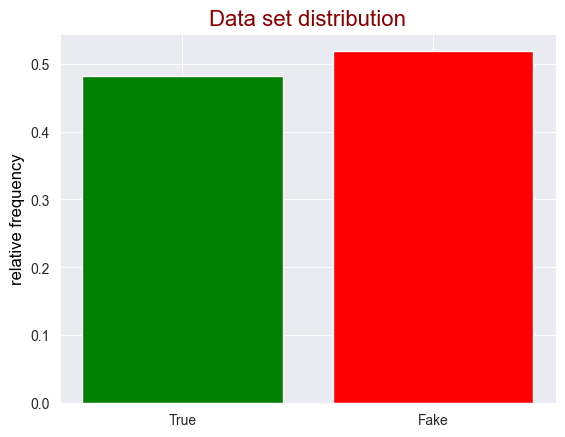

In [ ]:
true_false_count = train_combined["true"].value_counts()                                                            #counting all true values
print(f"Absolute frequency: {true_false_count}\n\n")

fake_count = true_false_count[0] / train_combined.shape[0]                                                          #dividing by the shape (instances) to get the percentage
true_count = true_false_count[1] / train_combined.shape[0]

true_frequency = f"Relative frequency of True: {true_count} \nRelative frequency of Fake: {fake_count}"
print(f"{true_frequency}\n\n")

sns.set_style("darkgrid")
plt.bar(["True", "Fake"], [true_count, fake_count], color=["green", "red"])                                         #bar plot for True and Fake to make it more appealing
plt.title("Data set distribution", fontdict=font_header)
plt.ylabel("relative frequency", fontdict=font)
plt.show()

Here we can see the **relative** frequency of **True** and **Fake**. We can conclude, that our *train_combined* DataFrame is almost fully balanced, since there are 48,2% of true news and 51,8% of fake news. There is a different of roughly 5%, but this is not a problem for the following algorithms.

**Important note**: We´re using *shuffle* in the splitting process, so these values will change if this code is run again, however, it won´t change drastically. Another option would be not shuffling the data, but we won´t do that to guarantee "randomness" in the training and test set.

As the next step, we will have a look at the subjects, to see which subjects appear, how they are distributed and whether there´s a difference between **true** and **fake**.

In [ ]:
groups = train_combined["subject"].value_counts()                                                                                         #counting all subjects in the train set
groups_fake = train_combined_fake["subject"].value_counts()                                                                               #counting all fake subjects
groups_true = train_combined_true["subject"].value_counts()                                                                               #counting all true subjects

groups_fake_relative = groups_fake / np.sum(groups_fake)                                                                                  #dividing by sum to get percentage for fake, then for true, then for both combined
groups_true_relative = groups_true / np.sum(groups_true)
groups_relative = train_combined["subject"].value_counts() / train_combined.shape[0]

groups_info_absolute = "\n\n".join([f"Absolute frequency of subjects: \n\n\
Combined table: \n{groups}", f"Fake subjects: \n{groups_fake}", f"True subjects: \n{groups_true}"])

groups_info_relative = "\n\n".join([f"Relative frequency of subjects: \n\n"\
f"Combined table: \n{groups_relative}", f"Fake subjects: \n{groups_fake_relative}", f"True subjects: \n{groups_true_relative}"])

print(groups_info_absolute)
print(groups_info_relative)

Absolute frequency of subjects: 

Combined table: 
subject
politicsNews       7966
worldnews          7178
News               6252
politics           4758
left-news          3103
Government News    1129
US_News             530
Middle-east         512
Name: count, dtype: int64

Fake subjects: 
subject
News               6252
politics           4758
left-news          3103
Government News    1129
US_News             530
Middle-east         512
Name: count, dtype: int64

True subjects: 
subject
politicsNews    7966
worldnews       7178
Name: count, dtype: int64
Relative frequency of subjects: 

Combined table: 
subject
politicsNews       0.253468
worldnews          0.228395
News               0.198931
politics           0.151394
left-news          0.098734
Government News    0.035923
US_News            0.016864
Middle-east        0.016291
Name: count, dtype: float64

Fake subjects: 
subject
News               0.383935
politics           0.292189
left-news          0.190555
Government News

Now we can see a huge list of of frequencies, which shows quite a lot information. Let´s plot these to understand it easier without needing to study the numbers.

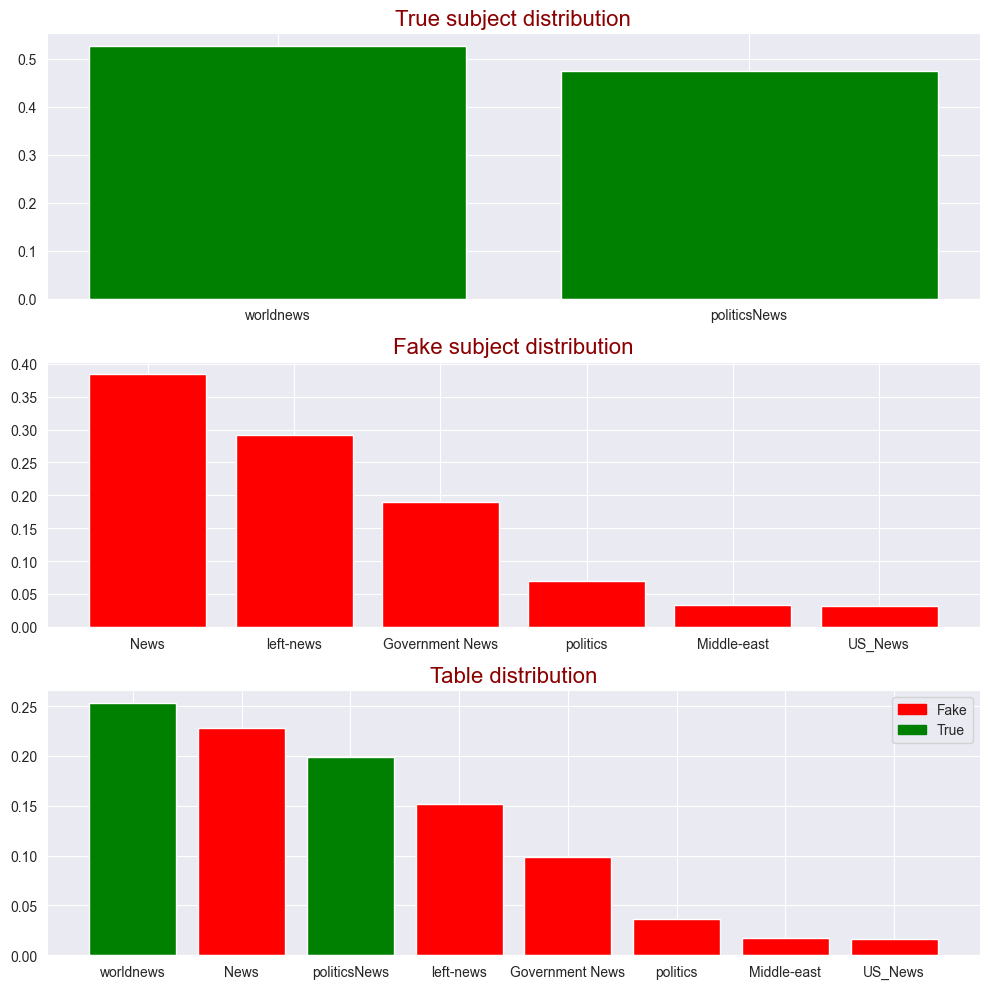

In [ ]:
fig, ax = plt.subplots(3, 1, figsize=(10, 10))                                                                          #creating a "3 in 1" plot

ax[0].bar(train_combined_true["subject"].unique(), groups_true_relative, color="green")                                 #creating a bar plot with the subject for x, relative frequencies for y
ax[0].set_title("True subject distribution", fontdict=font_header)

ax[1].bar(train_combined_fake["subject"].unique(), groups_fake_relative, color="red")
ax[1].set_title("Fake subject distribution", fontdict=font_header)

colors = np.where(np.isin(train_combined["subject"].unique(), ["politicsNews", "worldnews"]), "green", "red")
ax[2].bar(train_combined["subject"].unique(), groups_relative, color=colors)
red_patch = mpatches.Patch(color="red", label="Fake")
green_patch = mpatches.Patch(color="green", label="True")
ax[2].legend(handles=[red_patch, green_patch])
ax[2].set_title("Table distribution", fontdict=font_header)

fig.tight_layout()
plt.show()

This shows a lot of useful information:
1. The first thing you will notice, is that the true news consist of only 2 subjects; *worldnews* and *politicsNews*, whereas fake news consists of *News*, *US_News*, *politics*, *Government News*, *Middle-east* and *left-news*.
2. In the true news set the two subjects are more or less evenly distributed, while in Fake News most of the articles are labeled as *News* (≈38,4%).
3. If you have a look at the overall distribution, you will see, that *worldnews* is the most dominant table, followed by the labels *News* and *politics_news*.
4. This is **highly** biased based on these subjects.

⇒ As a conclusion it can be said, that the subjects of **True News** are only two evenly distributed labels, while **Fake News** has more labels and more imbalanced subjects with one very dominant label.

**Important note:** As the splitting process shuffles, this might change a bit if run again.

After looking at the *subjects* of the data, we will now consider the **dates**, when most of the articles were published. Let´s get the plain data of the 25 most frequent dates first and convert them into a better format with as little loss as possible.

In [ ]:
train_combined["date"] = pd.to_datetime(train_combined["date"], format="mixed", errors="coerce")                       #convert into DateTime with different formats
wrong_conversion = train_combined["date"].isna().sum()                                                                 #count NaT to see how good or bad the conversion was
train_combined_date_string = train_combined["date"].dt.strftime('%Y-%m-%d')                                            #back to string, DateTime hard to handle for plots

print(f"Check whether format is correct: \n{train_combined['date']}\n\n")
print(f"{wrong_conversion} conversions were not successful. \n\n")


dates = train_combined_date_string.unique()                                                                                                           #getting the "date" column
dates_frequency = np.array(train_combined["date"].value_counts())                                                                                     #counting how oft every date appears

dates_info = f"There are {len(dates)} unique dates in {len(train_combined)} data points, with the highest frequency {dates_frequency[0]}, \
which makes {np.sum(dates_frequency)} in total + {wrong_conversion} unsuccessful conversions."                                                        #checking frequency of dates, highest frequency and their sum to check for mistakes in the calculation
most_frequent_dates = train_combined_date_string.value_counts()[:25]                                                                                  #looking at indices 0 to 25
most_frequent_dates_info = f"The 25 most frequent dates are: \n{most_frequent_dates} \n"

print(f"{dates_info}\n\n")
print(most_frequent_dates_info)

Check whether format is correct: 
15130   2017-11-10
3215    2016-12-31
20915   2017-09-06
624     2017-08-08
9618    2016-05-10
           ...    
17124   2017-10-18
14321   2017-11-20
11001   2016-02-02
11088   2017-04-21
1524    2017-09-27
Name: date, Length: 31428, dtype: datetime64[ns]


7 conversions were not successful. 


There are 1006 unique dates in 31428 data points, with the highest frequency 136, which makes 31421 in total + 7 unsuccessful conversions.


The 25 most frequent dates are: 
date
2017-11-09    136
2017-09-21    136
2017-12-20    132
2017-11-30    131
2017-12-06    128
2017-10-12    126
2017-11-08    126
2017-09-26    125
2017-10-19    124
2017-10-26    122
2017-09-15    120
2017-09-22    119
2017-09-07    118
2017-10-13    116
2017-12-07    115
2017-12-21    115
2017-09-06    114
2017-10-24    113
2017-10-18    112
2017-11-17    111
2017-11-02    111
2017-10-25    111
2017-09-28    109
2017-09-13    109
2017-09-19    108
Name: count, dtype: int64 



We lost 7 dates, which is acceptable, considering the fact that there are links instead of dates in some cases. \
Before further analysis, let´s plot these values and their relative frequency.

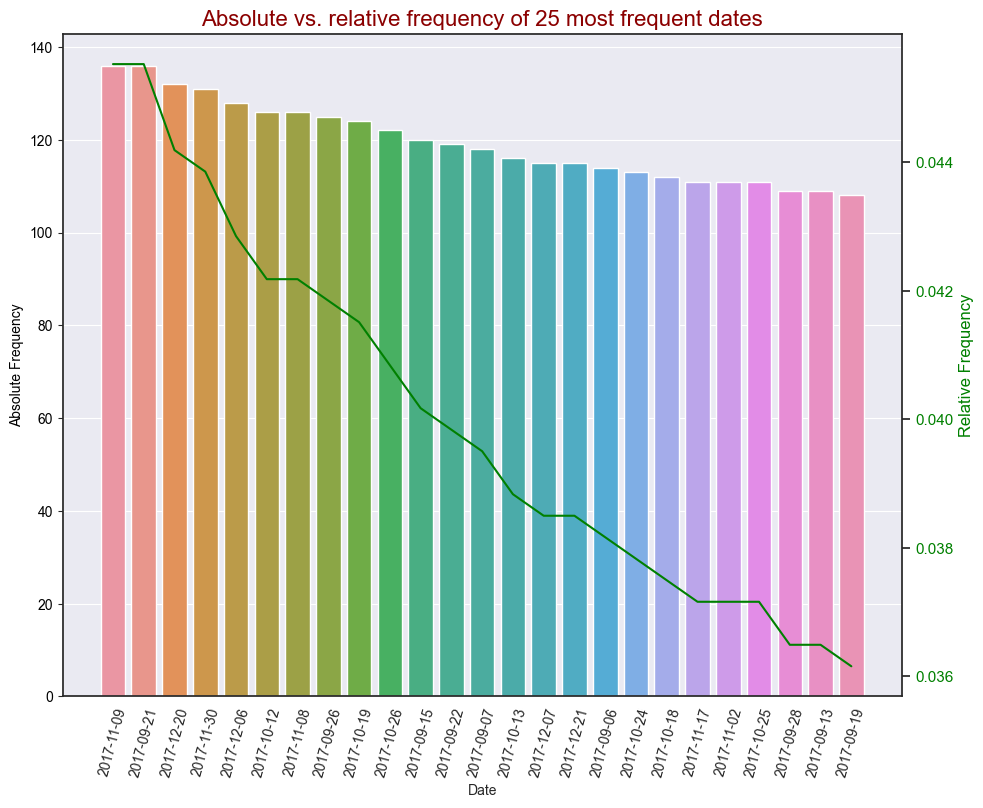

In [ ]:
fig, ax1 = plt.subplots(figsize=(10, 8))

sns.set_theme(style="white", palette="pastel")
sns.barplot(x=most_frequent_dates.index, y=most_frequent_dates.values, ax=ax1)
ax1.set_xlabel("Date")
ax1.set_ylabel("Absolute Frequency", color="black")
ax1.tick_params(axis="y", labelcolor="black")
ax1.tick_params(axis="x", rotation=75)

ax2 = ax1.twinx()

sns.lineplot(x=most_frequent_dates.index, y=most_frequent_dates.values / np.sum(most_frequent_dates), ax=ax2, color="green")                                      #dividing by sum for relative frequency
ax2.set_ylabel("Relative Frequency", color="green")
ax2.tick_params(axis="y", labelcolor="green")


fig.tight_layout()
plt.title("Absolute vs. relative frequency of 25 most frequent dates", fontdict=font_header)
plt.show()

In this plot, we see the absolute and relative frequency of the publishing dates.
It is quite obvious, that the 25 most frequent dates are all from 2017, many of them from December or October. Generally speaking all of them range from September to December. \

There can be multiple reasons for that. In our opinion, the most realistic explanation is that news coverage was particularly intensive during this period due to the following topics:
- Russian [Interference](https://www.rferl.org/a/russia-fake-news-reeled-in-2017/28943762.html) and spread of misinformation, also about the U.S. election.
- U.S. Presidential [Administration](https://en.wikipedia.org/wiki/Timeline_of_the_Donald_Trump_presidency_(2017_Q3))
- ["Antifa Plans Civil War on November 4th"](https://www.pbs.org/newshour/nation/google-top-stories-featured-false-news-rumored-antifa-civil-war)
- International [Developments](https://www.mei.edu/publications/2017-review-year-war-trump-and-geopolitical-shifts)

Now let´s look at the range of our train set:

In [ ]:
print(f"The first date in our train set is: {train_combined['date'].min()}")
print(f"The last date in our train set is: {train_combined['date'].max()}")

The first date in our train set is: 2015-03-31 00:00:00
The last date in our train set is: 2018-02-19 00:00:00


Before finishing the **date** column, let´s also consider the big picture here:

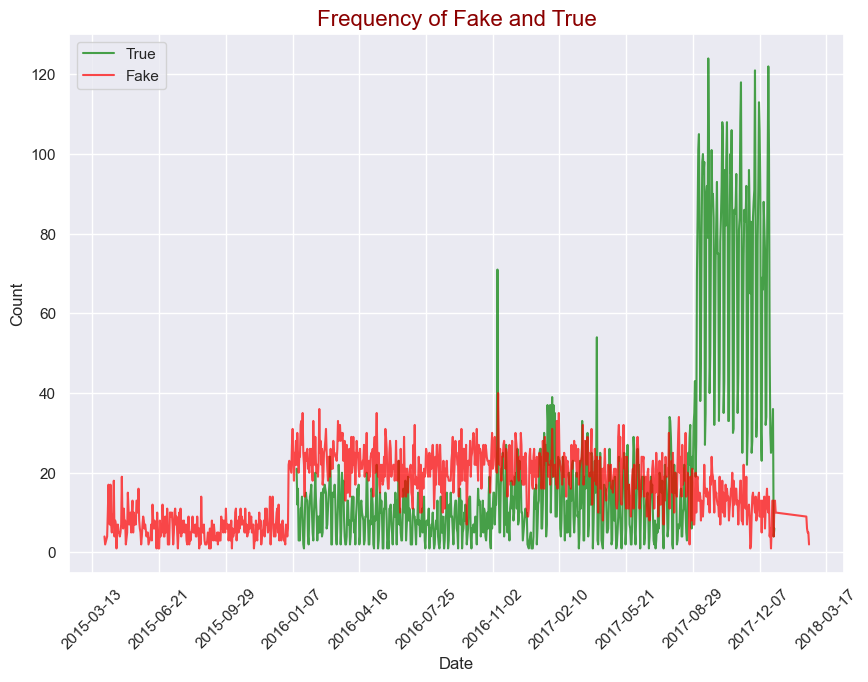

In [ ]:
date_true_fake = train_combined[train_combined["true"] == 0].groupby(["date"])["true"].count()              #every "fake" labeled row gets of comumn "true" gets counted
date_true_fake = pd.DataFrame(date_true_fake)

date_true_true = train_combined[train_combined["true"] == 1].groupby(["date"])["true"].count()              #every "true" labeled row gets of comumn "true" gets counted
date_true_true = pd.DataFrame(date_true_true)

sns.set_theme(style="darkgrid", palette="pastel")
pastel_red =(1.0, 0.6, 0.6)
pastel_green = (0.6, 0.8, 0.7, 1.0)

fig, ax = plt.subplots(figsize=(10, 7))

sns.lineplot(data=date_true_true, x=date_true_true.index, y="true", color="green", label="True", alpha=0.7, ax=ax)
sns.lineplot(data=date_true_fake, x=date_true_fake.index, y="true", color="red", label="Fake", alpha=0.7, ax=ax)

ax.set_xlabel("Date")
ax.set_ylabel("Count")
ax.set_title("Frequency of Fake and True", fontdict=font_header)
ax.legend()

ax.xaxis.set_major_locator(mdates.DayLocator(interval=100))

plt.xticks(rotation=45)
plt.show()

We can see, that we have no *true* data available before 2016. Until 2017 *fake* is more dominant, except for one big outlier at 2016-11-02. After 2017-08-29 *true* is way more dominant. We can conclude, that also the dates are pretty biased.

After analyzing the **Date** column and the **Subject** column, we will now look at the **Text** column of the train set. \
Before showing actual results, we will do some text preparation to get better results.

In [ ]:
stopwords = set(nltk.corpus.stopwords.words("english"))
string.punctuation += '’'

def preprocess_text(text):
    tokens = word_tokenize(text.lower())
    tokens = [word for word in tokens if word not in stopwords]
    tokens = [text_preprocessing(word) for word in tokens]
    return " ".join(tokens)

def text_preprocessing(text):
    text = re.sub(r"(\w+)\.(\w+)", r"\1 \2", text)
    text = text.translate(str.maketrans("", "", string.punctuation))
    return text


train_combined["title"] = train_combined["title"].apply(preprocess_text)
train_combined["title_text"] = train_combined["title_text"].apply(preprocess_text)
train_combined["text"] = train_combined["text"].apply(preprocess_text)

test_combined["title"] = test_combined["title"].apply(preprocess_text)
test_combined["title_text"] = test_combined["title_text"].apply(preprocess_text)
test_combined["text"] = test_combined["text"].apply(preprocess_text)

train_text_fake = train_combined.loc[train_combined["true"] == 0, "text"]
train_text_true = train_combined.loc[train_combined["true"] == 1, "text"]

We´re removing stopwords with the library nltk, we also delete punctuation and lower every letter. That makes the text easier to work with. Besides that we also cut out links, since something like "pic.twitter.com" is not valuable information. Also, by looking at the data, we saw that in Fake.csv are formatting issues like "Trump.The". To avoid problems, we fix this by deleting the dot and adding a blank space.

Now let´s get some intuition for our text with 2 wordclouds for *true* and *fake*. We also discussed showing barplots in the first place, but decided to use worldclouds instead, since - given the huge number of words in the data set - the wordclouds offer a bigger picture and give us the opportunity to get a lot of feeling for the text with one look.

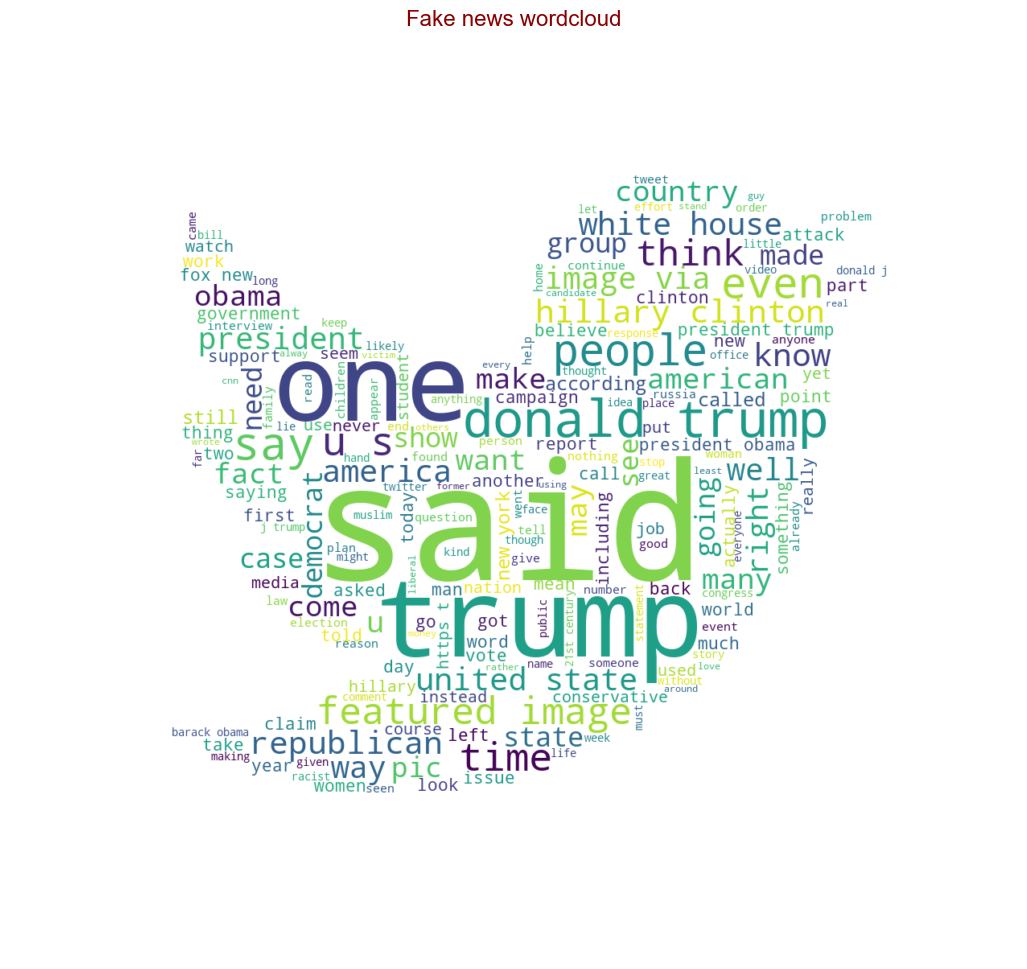

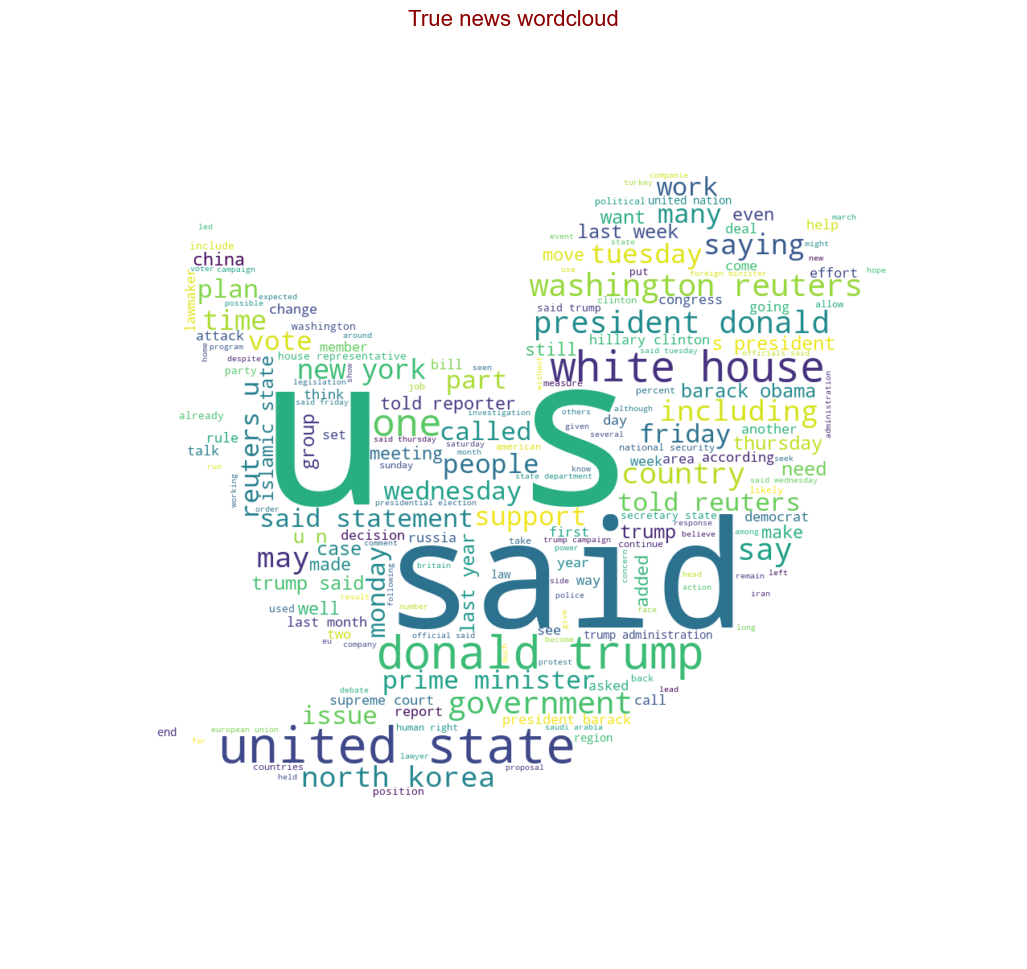

In [ ]:
train_text_fake = train_combined.loc[train_combined["true"] == 0, "text"]
train_text_true = train_combined.loc[train_combined["true"] == 1, "text"]
mask = np.array(Image.open("twitter.jpg"))

fake_wordcloud = WordCloud(mask=mask, background_color="white").generate(" ".join(train_text_fake))
plt.figure(figsize=(13,13))
plt.imshow(fake_wordcloud, cmap=plt.cm.gray, interpolation="bilinear")
plt.axis("off")
plt.title("Fake news wordcloud", fontdict=font_header)
plt.show()

print("\n\n")

true_wordcloud = WordCloud(mask=mask, background_color="white", width=1920, height=1080).generate(" ".join(train_text_true))
plt.figure(figsize=(13,13))
plt.imshow(true_wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("True news wordcloud", fontdict=font_header)
plt.show()

As expected, "said" and "US" are the most frequent words in the train set. Besides that, you can see a lot of "Trump" and other words connected to politics. However, fake news seem to often use pictures and show them as a source, since there is also a considerable amount of "Image". \
A really important information is here, that "*Washington Reuters*" is only in **true**. This is the case, because many texts in the **true** data set begin with these words. Reuters is an international news agency, which was used for true news in the data set. It is important to keep that in mind, because that is a very critical point to predict whether something is true or fake. It is obvious that it will be necessary to make some adjustments for the algorithms to work properly. Texts originating from Reuters may always be true in this data set, but not necessarily in the real world. \
Besides that you can see, that *true* is a bit more international, you see "United Nations" or "European Union", whereas *fake* is basically only about Trump, Election and the U.S. itself.

Let´s now have a closer look at the strings itself. We will consider the length of the strings and the number of words in every string.

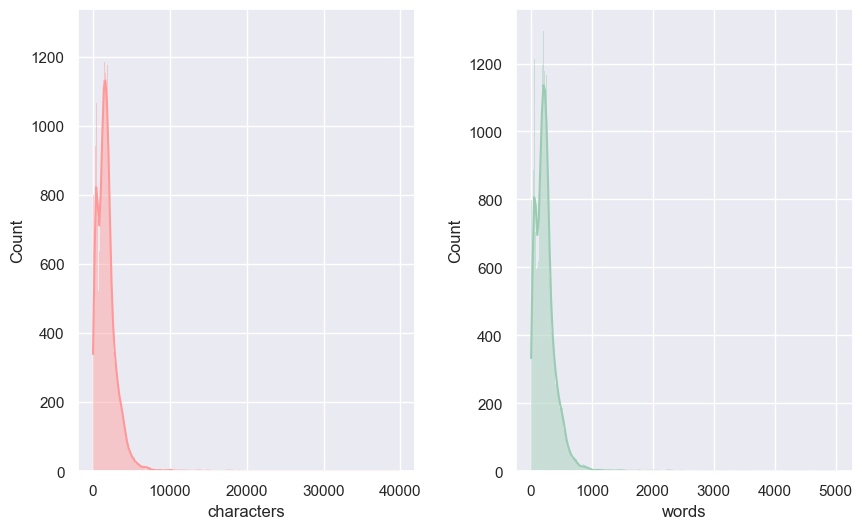

In [ ]:
length = train_combined["text"].apply(len)                                                  #length of strings in train_combined
words = [len(str(x).split()) for x in train_combined["text"]]                               #amount of words in string

pastel_red =(1.0, 0.6, 0.6)
pastel_green = (0.6, 0.8, 0.7, 1.0)

fig, axes = plt.subplots(1, 2, figsize=(10,6), gridspec_kw={"wspace": 0.3})
sns.histplot(length, ax=axes[0], kde=True, color=pastel_red)
sns.histplot(words, ax=axes[1], kde=True, color=pastel_green)
axes[1].set_xlabel("words")
axes[0].set_xlabel("characters")
plt.show()

Here we can conclude, that most of the text has between 0 and 5000 letters, some go up to 10000. In terms of words the maximum is at around 1200, also with the average being around 500 words, rarely going up to 1000. So we can indeed confirm, that this is a big data set with longs texts.

Let´s get a closer look at these words:

{'said': 93511, 'trump': 91989, 'would': 38289, 'president': 37303, 'people': 29187, 'one': 25438, 'state': 22747, 'also': 22015, 'new': 21905, 'reuters': 20414, 'donald': 19627, 'clinton': 19466, 'obama': 19256, 'house': 19187, 'government': 19105, 'states': 18817, 'republican': 17023, 'could': 16665, 'united': 16448, 'told': 16388}




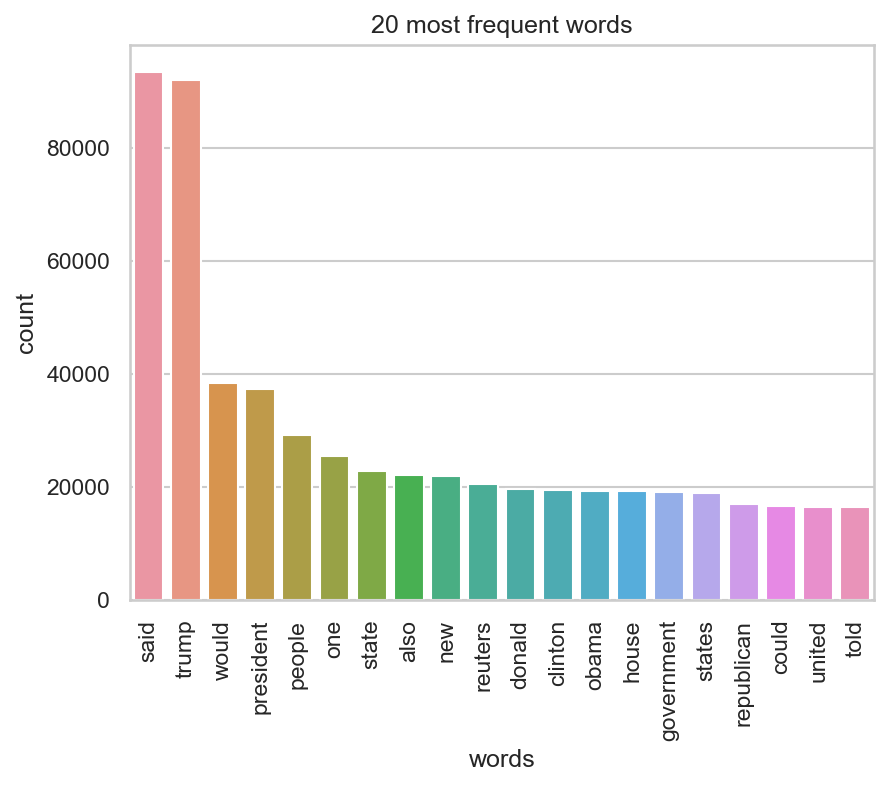

In [ ]:
vect = CountVectorizer(max_features=20)                                                                                                           #define CountVectorizer with max. 20 features

word_counts_vect = vect.fit_transform(train_combined["text"])                                                                                     #fitting the data, i.e. vocabulary, then transform it into a matrix
vocabulary = vect.get_feature_names_out()                                                                                                         #save the features (=words) in a variable
counts = word_counts_vect.sum(axis=0).A1                                                                                                          #calculate the sum of the matrix columnswise, A1 makes it a 1D array

word_counts_dict = dict(zip(vocabulary, counts))                                                                                                  #get tuples of (word, count)
sorted_dict = dict(sorted(word_counts_dict.items(), key=lambda x: x[1], reverse=True))                                                            #sort the dictionary, but reversed, such that the biggest value comes first

print(f"{sorted_dict}\n\n")

plt.figure(dpi=150)
sns.set_theme(style="whitegrid", palette="pastel")
sns.barplot(x=list(sorted_dict.keys()), y=list(sorted_dict.values()))
plt.xticks(rotation=90)
plt.xlabel("words")
plt.ylabel("count")
plt.title("20 most frequent words")
plt.show()

As you might have already guessed from the worldcloud, "Trump" and "said" absolutely dominate the top 20 frequent words in the barplot, the 18 left words are closer to each other. At this point also note "reuters" once again, which might cause problems later.

But we won´t only consider the most frequent words, we will also have a look at **bigrams** to see if something interesting can be seen there.

{'donald trump': 18435, 'united states': 13135, 'white house': 10422, 'hillary clinton': 6636, 'new york': 6179, 'featured image': 5259, 'president donald': 4928, 'washington reuters': 4567, 'image via': 4370, 'north korea': 4367, 'barack obama': 3970, 'trump said': 3469, 'last week': 3289, 'last year': 3261, 'prime minister': 3238, 'president trump': 3202, 'said statement': 3201, 'supreme court': 2929, 'president obama': 2922, 'fox news': 2868}




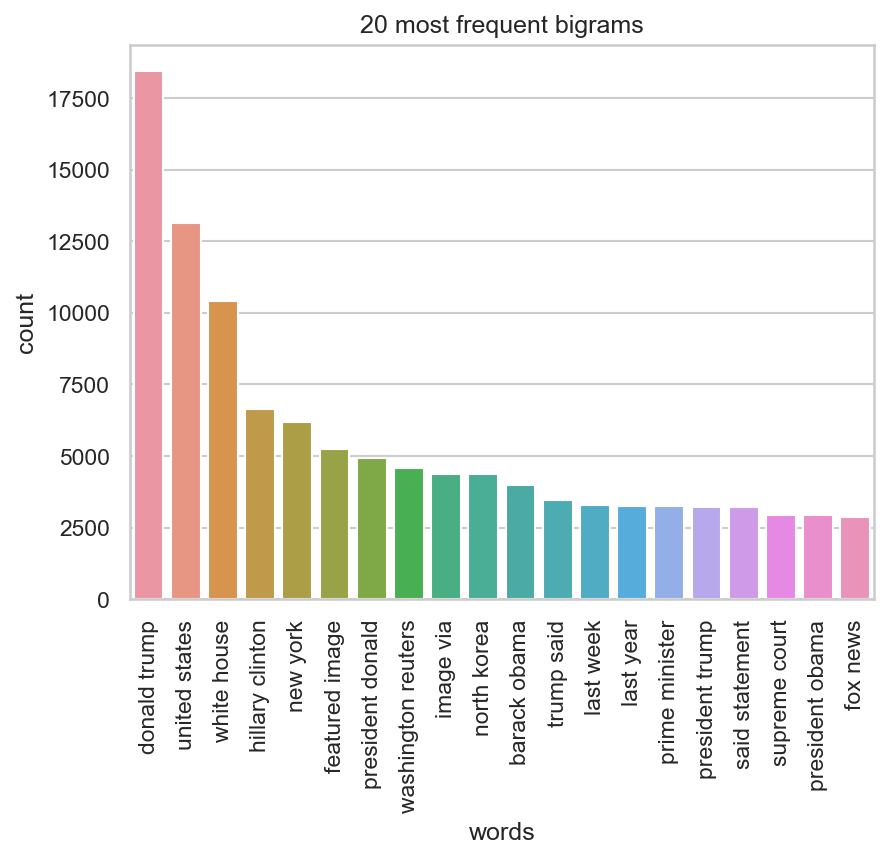

In [ ]:
vect = CountVectorizer(max_features=20, ngram_range=(2,2))                                                                          #doing the same steps as before, but looking only at bigrams: (2,2)

word_counts_vect = vect.fit_transform(train_combined["text"])
vocabulary = vect.get_feature_names_out()
counts = word_counts_vect.sum(axis=0).A1

word_counts_dict = dict(zip(vocabulary, counts))
sorted_dict = dict(sorted(word_counts_dict.items(), key=lambda x: x[1], reverse=True))

print(f"{sorted_dict}\n\n")

plt.figure(dpi=150)
sns.set_style("whitegrid")
sns.barplot(x=list(sorted_dict.keys()), y=list(sorted_dict.values()))
plt.xticks(rotation=90)
plt.xlabel("words")
plt.ylabel("count")
plt.title("20 most frequent bigrams")
plt.show()

This is also the expected output. You can see a lot of usual combinations of words, such as "New York" or "image via". "Trump" and "United States" dominate here. Now we can also observe "Washington Reuters". Since "President Donald" misses a word, this leads to the question, what happens if you use trigrams.

{'president donald trump': 4883, 'featured image via': 3937, 'president barack obama': 2690, 'new york times': 1449, '21st century wire': 1307, 'donald trump realdonaldtrump': 1266, 'reuters president donald': 1131, 'washington reuters president': 960, 'black lives matter': 945, 'president united states': 804, 'presidentelect donald trump': 770, 'white house said': 731, 'new york city': 727, 'president vladimir putin': 669, 'news 21st century': 643, 'affordable care act': 628, 'speaker paul ryan': 596, 'director james comey': 595, 'national security adviser': 589, 'former president barack': 563}




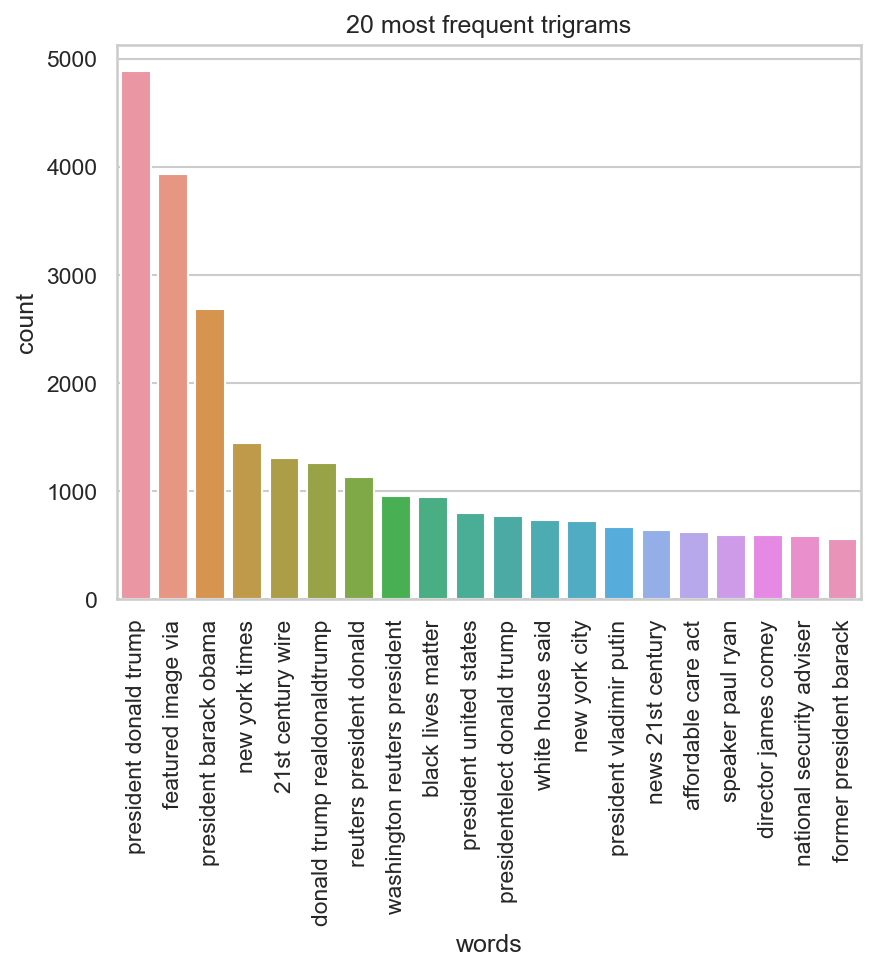

In [ ]:
vect = CountVectorizer(max_features=20, ngram_range=(3,3))

word_counts_vect = vect.fit_transform(train_combined["text"])
vocabulary = vect.get_feature_names_out()
counts = word_counts_vect.sum(axis=0).A1

word_counts_dict = dict(zip(vocabulary, counts))
sorted_dict = dict(sorted(word_counts_dict.items(), key=lambda x: x[1], reverse=True))

print(f"{sorted_dict}\n\n")

plt.figure(dpi=150)
sns.set_style("whitegrid")
sns.barplot(x=list(sorted_dict.keys()), y=list(sorted_dict.values()))
plt.xticks(rotation=90)
plt.xlabel("words")
plt.ylabel("count")
plt.title("20 most frequent trigrams")
plt.show()

"realdonaldtrump" is an interesting observation, this is obviously coming from a link to Trump´s Twitter and since the "@" was removed, you now see it as a word. Also, Putin appears in this plot, which was not the case for the other plots, which is pretty suprising.

At this point we´re finished with Data Exploration, since we got the information we needed to select a good model and avoid possible problems.
There may be more aspects that could have been analyzed, but we concentrated on covering those topics more deeply that will be important for the following steps. \
So let´s now go on with the Model Selection.


### 4. Model Selection

#### 4.1 Title and Text data only

Before fine-tuning the algorithms, we will use "quick and dirty" models with standard parameters and compare their performance.
Therefore we use 3-fold Cross Validation of the following algorithms:
+ Logistic Regression
+ Naive Bayes
+ Decision Trees
+ Random Forests
+ Gradient Boosting

Since the data set is relatively big, we will not use the K-Nearest Neighbours (KNN) algorithm. Since KNN is a distance based algorithm, the computation time would be very long and therefore not applicable. We are using 3 fold cross validation, since the computation time would be too high with more folds. Also note, that we cannot try more algorithms, since this would also result in an even longer computation time. Only these five algorithms already compute for a long time, fine-tuning them will be even longer. We could make the training set smaller, but this is not an option for us, as we will lose generality by doing that.

In [ ]:
log_reg = LogisticRegression(max_iter=2000)
nb = MultinomialNB()
dt = DecisionTreeClassifier()
rf = RandomForestClassifier()
gb = GradientBoostingClassifier()

param_vect = range(5000, 45001, 10000)
models = [log_reg, nb, dt, rf, gb]

best_params_dict = {}

param_grid = {"tfidf__max_df": param_vect,
              "tfidf__ngram_range": [(1, 1), (1, 2)]}

for model in models:
    pipeline = Pipeline([
        ("tfidf", TfidfVectorizer()),
        ("model", model)])

    random_search = RandomizedSearchCV(pipeline, param_grid, cv=3, scoring="accuracy", n_jobs=-1)
    random_search.fit(train_combined["title_text"], y_train)

    best_params_dict[model.__class__.__name__] = random_search.best_params_

    print(f"{model.__class__.__name__}:")
    print("Best parameters for vectorizer:", random_search.best_params_)
    print("Best mean accuracy:", random_search.best_score_)
    print("Variance of CV scores:", random_search.cv_results_["std_test_score"][random_search.best_index_] ** 2)
    print("\n")

LogisticRegression:
Best parameters for vectorizer: {'tfidf__ngram_range': (1, 1), 'tfidf__max_df': 25000}
Best mean accuracy: 0.9884497899961818
Variance of CV scores: 5.467140952078502e-08


MultinomialNB:
Best parameters for vectorizer: {'tfidf__ngram_range': (1, 2), 'tfidf__max_df': 25000}
Best mean accuracy: 0.9600674557719232
Variance of CV scores: 1.2533926849395055e-06


DecisionTreeClassifier:
Best parameters for vectorizer: {'tfidf__ngram_range': (1, 2), 'tfidf__max_df': 15000}
Best mean accuracy: 0.9965953926435026
Variance of CV scores: 7.492007971365973e-08


RandomForestClassifier:
Best parameters for vectorizer: {'tfidf__ngram_range': (1, 1), 'tfidf__max_df': 35000}
Best mean accuracy: 0.9933816978490517
Variance of CV scores: 1.4720783230225843e-06


GradientBoostingClassifier:
Best parameters for vectorizer: {'tfidf__ngram_range': (1, 2), 'tfidf__max_df': 35000}
Best mean accuracy: 0.9976772304950998
Variance of CV scores: 3.422025262597081e-07




In [ ]:
best_params_modified = {}
for model, params in best_params_dict.items():
    modified_params = {}
    for key, value in params.items():
        new_key = key.replace("tfidf__", "")
        modified_params[new_key] = value
    best_params_modified[model] = modified_params
best_params_modified

{'LogisticRegression': {'ngram_range': (1, 1), 'max_df': 25000},
 'MultinomialNB': {'ngram_range': (1, 2), 'max_df': 25000},
 'DecisionTreeClassifier': {'ngram_range': (1, 2), 'max_df': 15000},
 'RandomForestClassifier': {'ngram_range': (1, 1), 'max_df': 35000},
 'GradientBoostingClassifier': {'ngram_range': (1, 2), 'max_df': 35000}}

Here we can see, that the best performance for max_df is LogisticRegression and Decision Tree. RandomForest performs best for 35 thousand words, just as Gradient Boosting. We will drop NaiveBayes, since this performs the worst and it´s not worth fine-tuning it.

All algorithms have a high accuracy and a small variance, but Gradient Boosting has the best of all. Before fine-tuning, let´s have a look at the algorithms.
Also, Naive Bayes has the worst accuracy and the highest variance, so you can see the correlation between variance and accuracy there.

Gradient Boosting performs extraordinarily good, but it computes for an extremely long time. Therefore we will not fine-tune it. The time to compute is disproportionate to the results.

Let´s now analyze the  other algorithms and see how they work. After that we will fine-tune and see, whether an even better score is possible and which kind of errors appear.

As a first approach, we will look at the Decision Tree algorithm and look at the actual tree.
**Warning**: This tree will be really big, but we will leave it like that such that it is as similar as possible to the cross validation tree. Skip this tree if you want to see the smaller tree.

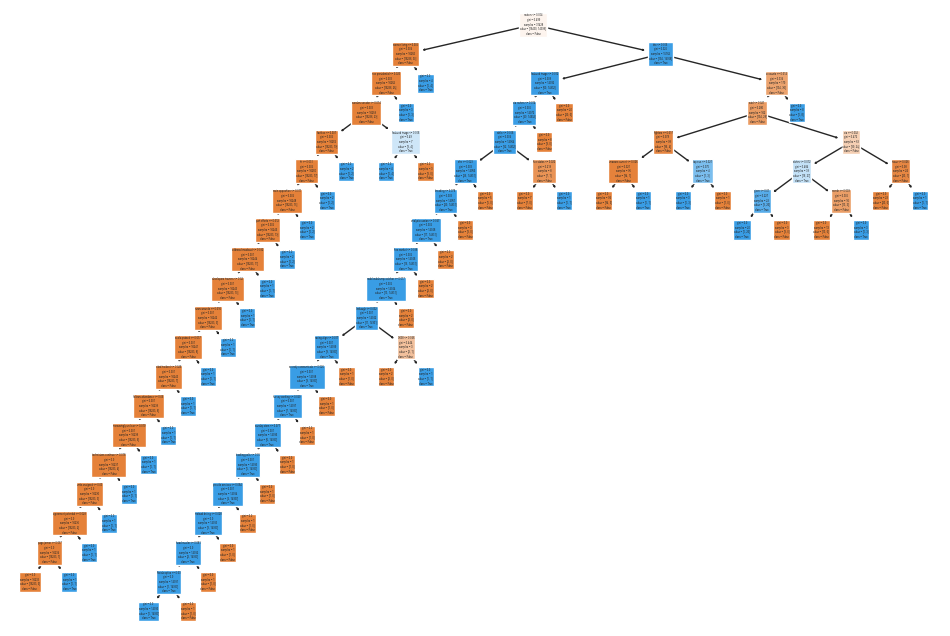

In [ ]:
vectorizer = TfidfVectorizer(**best_params_modified["DecisionTreeClassifier"])
feature_matrix = vectorizer.fit_transform(train_combined["title_text"])

dt.fit(feature_matrix, y_train)

class_names = ["True" if label == 1 else "False" for label in np.unique(y_train)]

plt.figure(figsize=(12, 8))
tree.plot_tree(dt, feature_names=list(vectorizer.get_feature_names_out()), class_names=class_names, filled=True)
plt.show()

Now, since this is too big to look at, we will only show the first few nodes to see what´s happening.

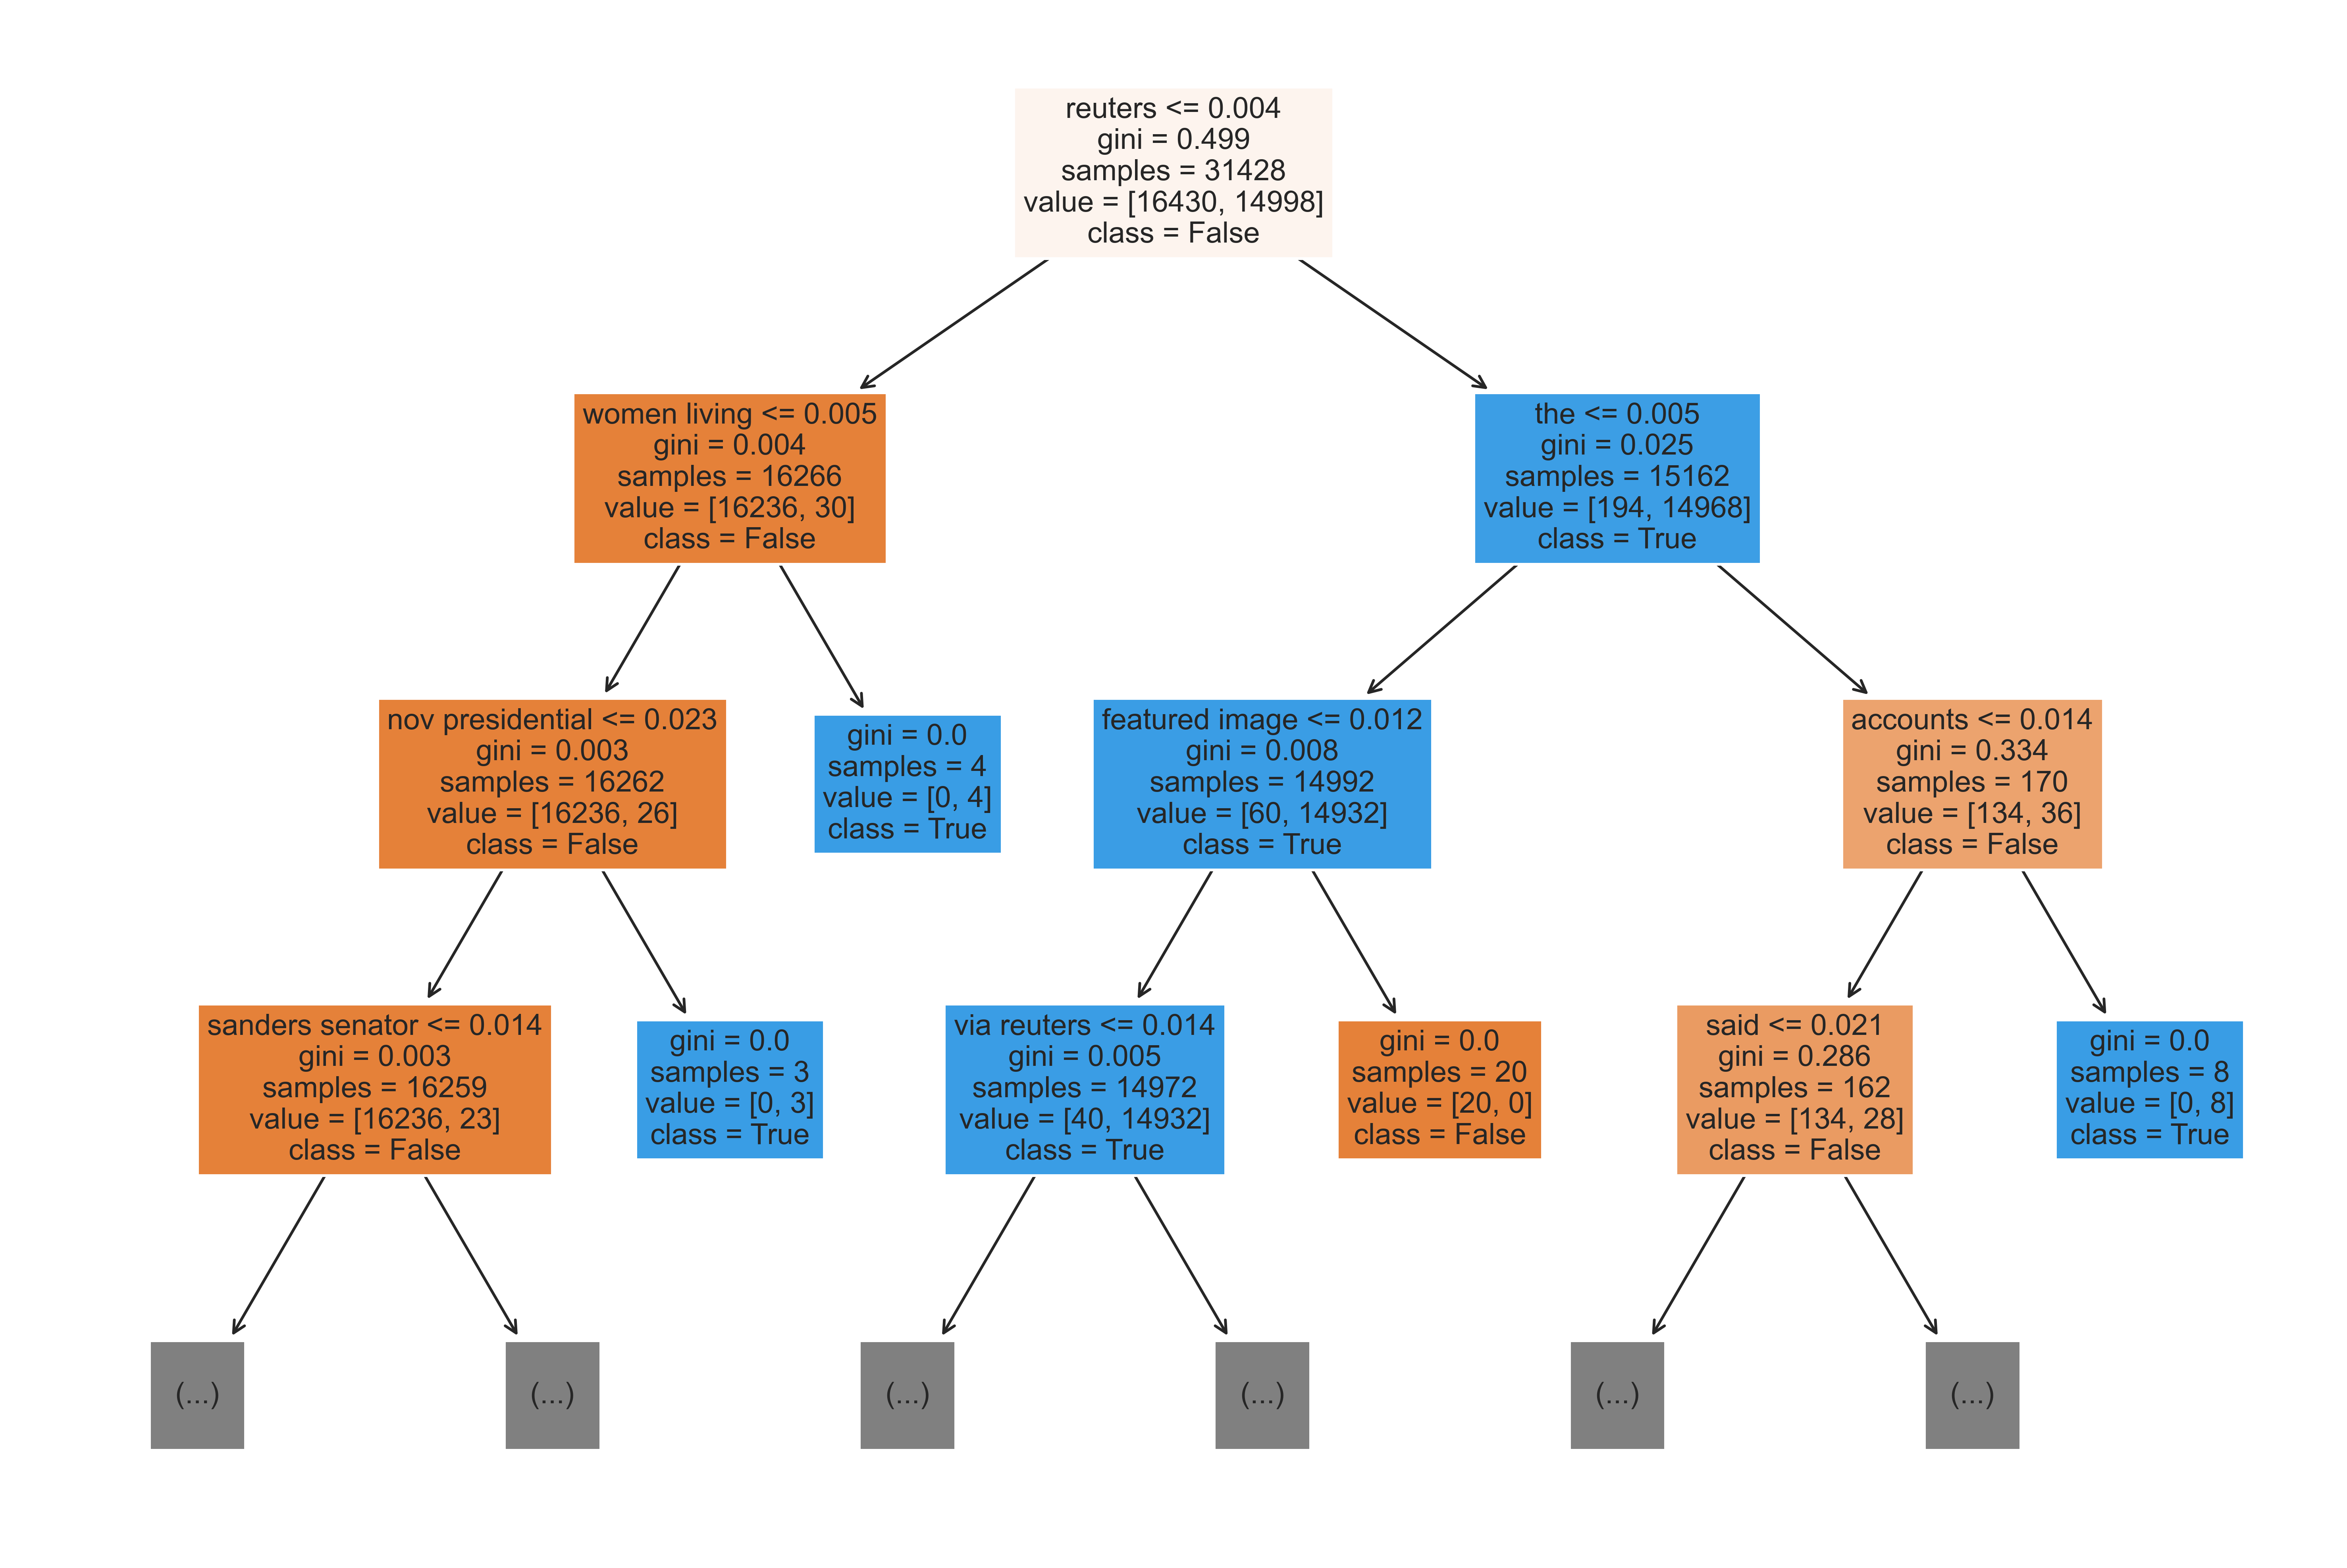

In [ ]:
class_names = ["True" if label == 1 else "False" for label in np.unique(y_train)]

plt.figure(figsize=(15, 10), dpi=500)
tree.plot_tree(dt, feature_names=list(vectorizer.get_feature_names_out()), class_names=class_names, filled=True, max_depth=3)
plt.show()

As expected, Reuters is really important, it is the root of the binary tree. The children of the root are already pretty clear splits, with the right one being shorter than the left one. This is the behavior as expected because of "Reuters". This also explains the extremely high accuracy. We will address this issue later. \
Let´s try to get the Decision tree even more precise, using GridSearch.

In [ ]:
param_grid = {
    "max_depth": [None, 5, 25, 45],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [2, 6, 10],
}

grid_search = GridSearchCV(dt, param_grid, cv=3, scoring="accuracy", n_jobs=-1)

grid_search.fit(feature_matrix, y_train)

best_params_dt = grid_search.best_params_
best_score_dt = grid_search.best_score_

print("Best Parameters:", best_params_dt)
print("Best Score:", best_score_dt)

Best Parameters: {'max_depth': 45, 'min_samples_leaf': 2, 'min_samples_split': 2}
Best Score: 0.9969453990072547


So these are the best parameters on our most precise model.
Let´s run it on the test set and see how it performs on unseen data.

Accuracy: 0.9956198960653304 

Classification Report: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7026
           1       1.00      0.99      1.00      6444

    accuracy                           1.00     13470
   macro avg       1.00      1.00      1.00     13470
weighted avg       1.00      1.00      1.00     13470




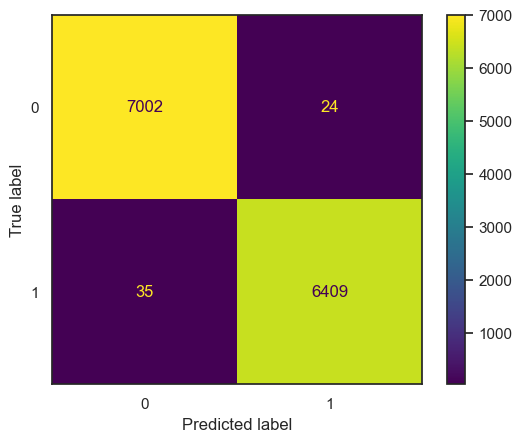

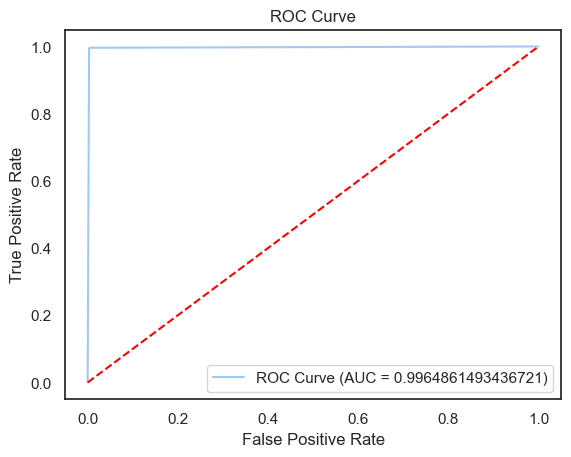

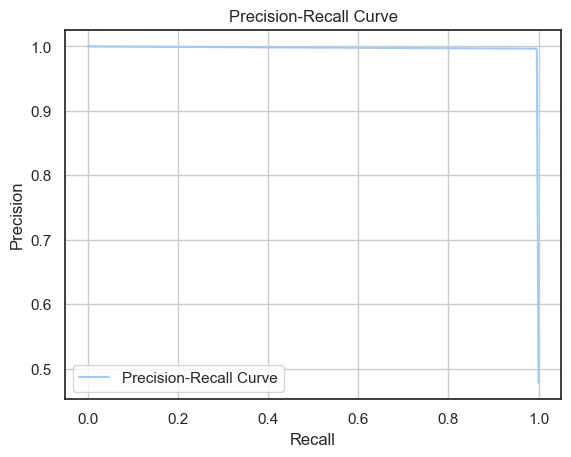

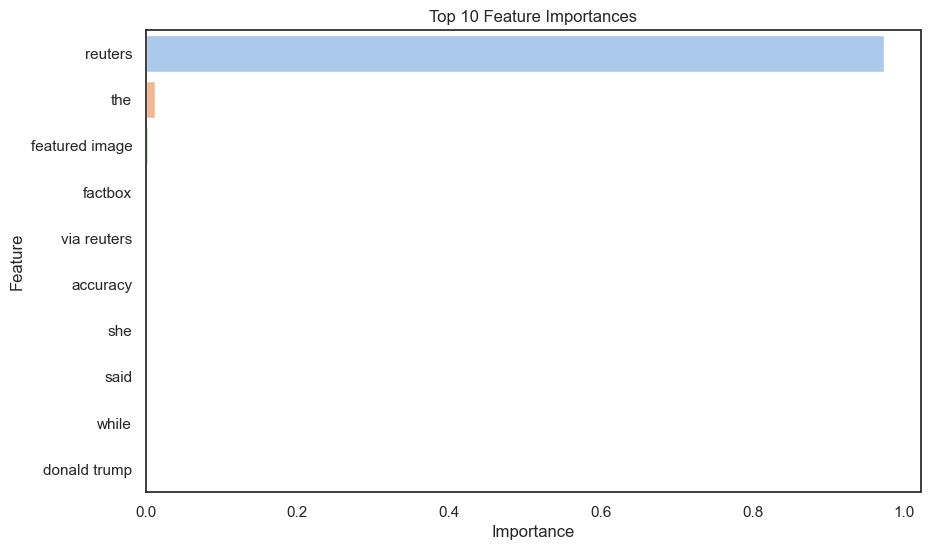

In [ ]:
feature_matrix_test = vectorizer.transform(test_combined["title_text"])

dt = DecisionTreeClassifier(**best_params_dt)
dt.fit(feature_matrix, y_train)

y_pred = dt.predict(feature_matrix_test)
y_proba = dt.predict_proba(feature_matrix_test)[:, 1]

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy} \n")

report = classification_report(y_test, y_pred)
print(f"Classification Report: \n{report}\n")

sns.set_style("white")
cm_dt = confusion_matrix(y_test, y_pred, labels=dt.classes_)
disp_dt = ConfusionMatrixDisplay(confusion_matrix=cm_dt, display_labels=dt.classes_)
disp_dt.plot()
plt.show()

print("\n")

fpr_dt, tpr_dt, thresholds_dt = roc_curve(y_test, y_proba)
auc_dt = roc_auc_score(y_test, y_proba)

plt.plot(fpr_dt, tpr_dt, label=f"ROC Curve (AUC = {auc_dt})")
plt.plot([0, 1], [0, 1], color="red", linestyle="--")

print("\n")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")

plt.show()

print("\n")

precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
plt.plot(recall, precision, color="b", label="Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.grid(True)
plt.show()

print("\n")

feature_importances = dt.feature_importances_
indices = np.argsort(feature_importances)[::-1]
top_features = indices[:10]
top_importances = feature_importances[top_features]
feature_names = vectorizer.get_feature_names_out()

plt.figure(figsize=(10, 6))
sns.barplot(x=top_importances, y=[feature_names[i] for i in top_features])
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Top 10 Feature Importances (Decision Tree)")
plt.show()

As we can see, the DecisionTree classifier performs extremely well and only has 59 wrong classifications. 24 are false negative, meaning predicted true, but actually fake.
As we can see in the Importance graph, Reuters has a huge importance. You could argue it´s only decided via "Reuters". This might be good for this data set, but it´s not for generality. We will address this later. The rest of the metrics is phenomenal. It performs well on all of them.

Now let´s have a look at logistic regression.

We will again try to find the best parameters and see how it performs.

In [ ]:
vectorizer = TfidfVectorizer(**best_params_modified["LogisticRegression"])
feature_matrix = vectorizer.fit_transform(train_combined["title_text"])
feature_matrix_test = vectorizer.transform(test_combined["title_text"])

log_reg = LogisticRegression()
param_grid = {"C": [0.01, 0.1, 1, 100, 1000],
             "penalty": ["l1", "l2"],
              "solver": ["liblinear", "saga"],
              "max_iter": [3000, 4000]}

grid_search = GridSearchCV(log_reg, param_grid, cv=3, scoring="accuracy", n_jobs=-1)

grid_search.fit(feature_matrix, y_train)

best_params_log_reg = grid_search.best_params_
best_score_log_reg = grid_search.best_score_

print("Best Parameters:", best_params_log_reg)
print("Best Score:", best_score_log_reg)

Best Parameters: {'C': 100, 'max_iter': 4000, 'penalty': 'l1', 'solver': 'liblinear'}
Best Score: 0.9974863179330534


Now we got the best possible parameters with a really high accuracy again, which is way higher than the naive model. Let´s fit that model and evaluate it.

Accuracy: 0.9973273942093541 

Classification Report: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7026
           1       1.00      1.00      1.00      6444

    accuracy                           1.00     13470
   macro avg       1.00      1.00      1.00     13470
weighted avg       1.00      1.00      1.00     13470




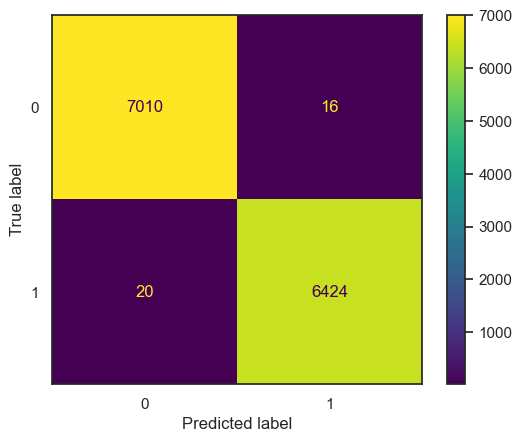

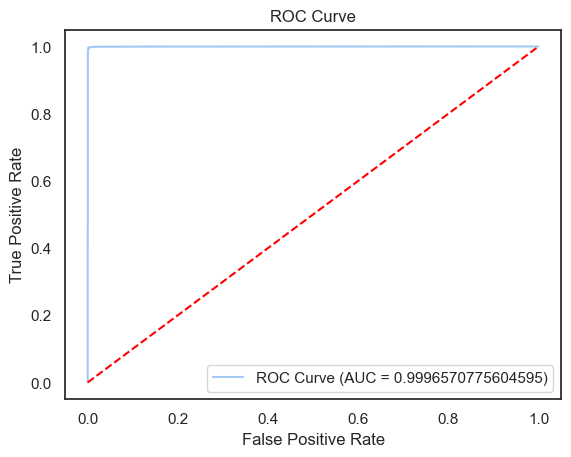

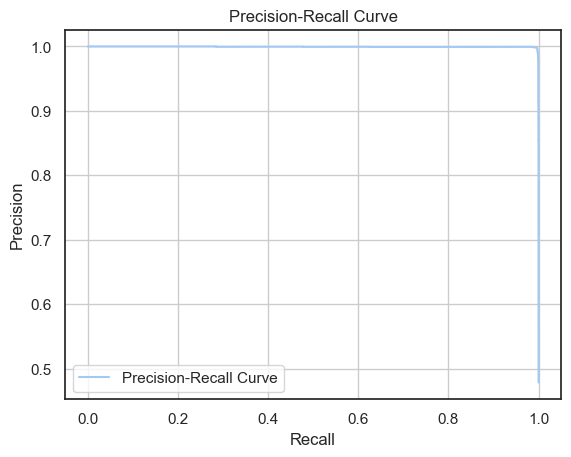

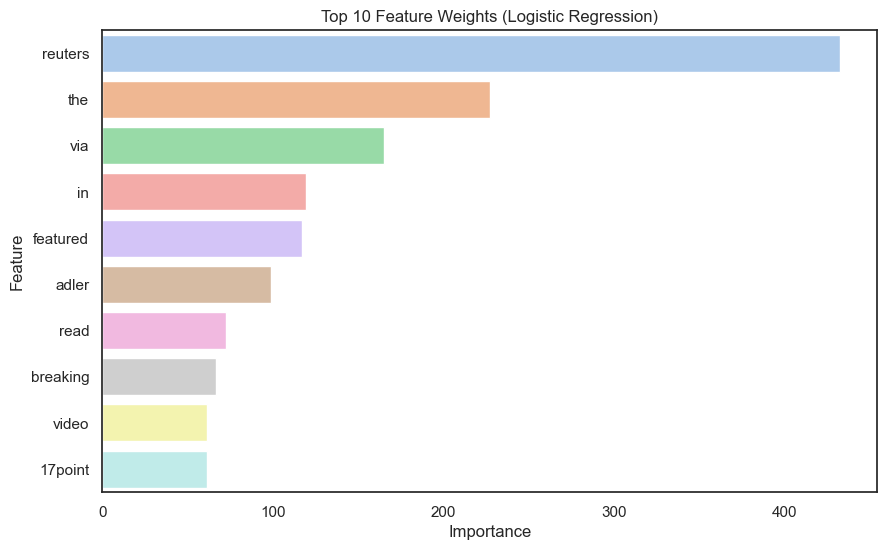

In [ ]:
log_reg = LogisticRegression(**best_params_log_reg)
log_reg.fit(feature_matrix, y_train)

y_pred = log_reg.predict(feature_matrix_test)
y_proba = log_reg.predict_proba(feature_matrix_test)[:, 1]

accuracy_log_reg = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy_log_reg} \n")

report_log_reg = classification_report(y_test, y_pred)
print(f"Classification Report: \n{report_log_reg}\n")

sns.set_style("white")
cm_log_reg = confusion_matrix(y_test, y_pred, labels=log_reg.classes_)
disp_log_reg = ConfusionMatrixDisplay(confusion_matrix=cm_log_reg, display_labels=log_reg.classes_)
disp_log_reg.plot()
plt.show()

print("\n")

fpr_log_reg, tpr_log_reg, thresholds_log_reg = roc_curve(y_test, y_proba)
auc_log_reg = roc_auc_score(y_test, y_proba)

plt.plot(fpr_log_reg, tpr_log_reg, label=f"ROC Curve (AUC = {auc_log_reg})")
plt.plot([0, 1], [0, 1], color="red", linestyle="--")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")

plt.show()

print("\n")

precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
plt.plot(recall, precision, color="b", label="Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.grid(True)
plt.show()

feature_importances = abs(log_reg.coef_[0])
indices = np.argsort(feature_importances)[::-1]
top_features = indices[:10]
top_importances = feature_importances[top_features]
feature_names = vectorizer.get_feature_names_out()

plt.figure(figsize=(10, 6))
sns.barplot(x=top_importances, y=[feature_names[i] for i in top_features])
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Top 10 Feature Weights (Logistic Regression)")
plt.show()

Here we also see some fantastic results. Although being slightly worse on the first approach, Logistic Regression is a bit better now than the Decision tree and makes less wrong classification. We have 36 errors on 13470 tests, 16 false negative. This is awesome. Besides that you can see, that it performs almost perfectly on all other metrics.
Let´s now continue with RandomForest.

In [ ]:
vectorizer = TfidfVectorizer(**best_params_modified["RandomForestClassifier"])
rf = RandomForestClassifier()
feature_matrix = vectorizer.fit_transform(train_combined["title_text"])
feature_matrix_test = vectorizer.transform(test_combined["title_text"])

param_grid = {"n_estimators": [100, 200, 500, 1000],
              "max_depth": [5, 15, 25, 50, None],
              "max_features": [100, 1000, 5000, None],
              "criterion": ["gini", "entropy"]}

random_search = RandomizedSearchCV(rf, param_grid, cv=3, scoring="accuracy", n_jobs=-1)

random_search.fit(feature_matrix, y_train)

best_params_rf = random_search.best_params_
best_score_rf = random_search.best_score_

print("Best Parameters:", best_params_rf)
print("Best Score:", best_score_rf)

Best Parameters: {'n_estimators': 500, 'max_features': 5000, 'max_depth': 50, 'criterion': 'entropy'}
Best Score: 0.9984726995036274


We found the best values again with the best accuracy being 99,84%. Let´s test it on the test set.

Accuracy: 0.9979213066072754 

Classification Report: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7051
           1       1.00      1.00      1.00      6419

    accuracy                           1.00     13470
   macro avg       1.00      1.00      1.00     13470
weighted avg       1.00      1.00      1.00     13470




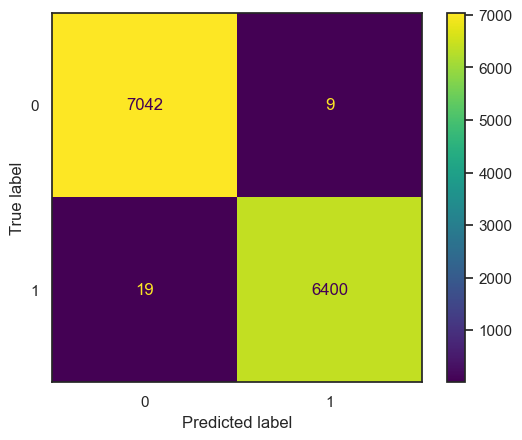

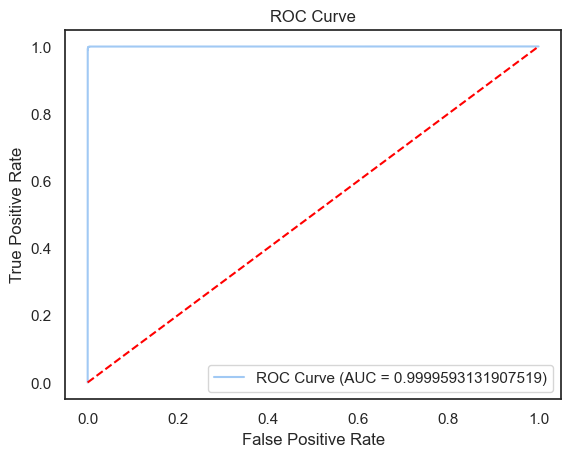

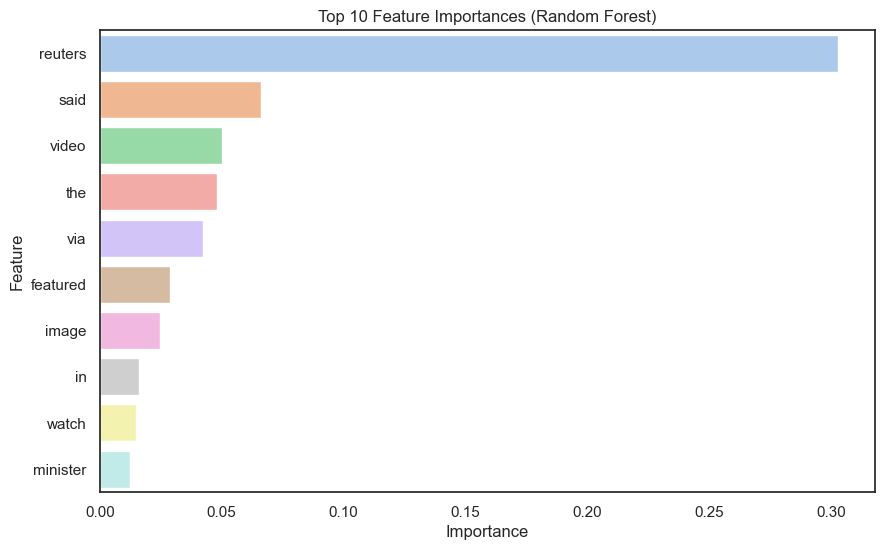

In [ ]:
rf = RandomForestClassifier(**best_params_rf)
rf.fit(feature_matrix, y_train)

y_pred = rf.predict(feature_matrix_test)
y_proba = rf.predict_proba(feature_matrix_test)[:, 1]

accuracy_rf = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy_rf} \n")

report_rf = classification_report(y_test, y_pred)
print(f"Classification Report: \n{report_rf}\n")

sns.set_style("white")
cm_rf = confusion_matrix(y_test, y_pred, labels=rf.classes_)
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=rf.classes_)
disp_rf.plot()
plt.show()

print("\n")

fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, y_proba)
auc_rf = roc_auc_score(y_test, y_proba)

plt.plot(fpr_rf, tpr_rf, label=f"ROC Curve (AUC = {auc_rf})")
plt.plot([0, 1], [0, 1], color="red", linestyle="--")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")

plt.show()

feature_importances = rf.feature_importances_
indices = np.argsort(feature_importances)[::-1]
top_features = indices[:10]
top_importances = feature_importances[top_features]
feature_names = vectorizer.get_feature_names_out()

plt.figure(figsize=(10, 6))
sns.barplot(x=top_importances, y=[feature_names[i] for i in top_features])
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Top 10 Feature Importances (Random Forest)")
plt.show()

Here we can clearly see now, that RandomForest also performs extraordinarily well. You can see that the ROC curve is basically like a square, the AUC is almost 1.0 and the importance graph reveals, that "Reuters" isn´t as important as it was for the Decision tree.
Since we´re not defining max_depth, the trees will be huge:

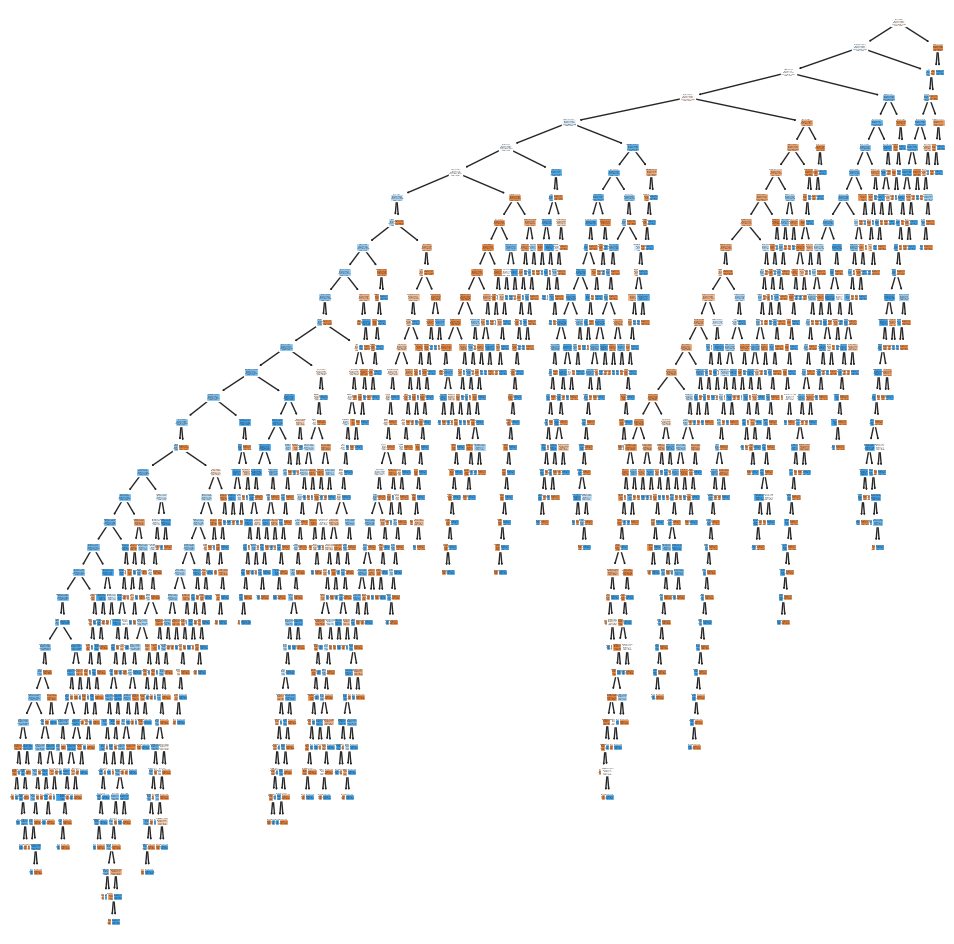

In [ ]:
single_tree = rf.estimators_[0]
class_names = ["True" if label == 1 else "False" for label in np.unique(y_train)]

feature_names = vectorizer.get_feature_names_out()                  #returns array

fig, ax = plt.subplots(figsize=(12, 12))
tree.plot_tree(single_tree, feature_names=list(feature_names), class_names=class_names, filled=True, ax=ax)     #using list, list is expected
plt.show()

And this is only one tree, there are 500 of these trees.
What is our conclusion after these algorithms?
+ Random Forest works best
+ Logistic Regression is **slightly** worse, followed closely by Decision Tree
+ Naive GradientBoost is already really good, but computes very long
⇒ Random Forest outperforms all the other algorithms, which makes it the best choice for this type of prediction. If we talk about naive models, GradientBoost was better and might also be better after fine-tuning, but doing this would take too long. The cross-validation took very long, GridSearch would talk even longer. This is disproportionate and makes Random Forest the most suitable algorithm. If you´re going for speed and still want the best possible results, Logistic Regression is the best choice.

#### Summary

Without restricting the data set and using biased data, Machine Learning algorithms are capable of predicting Fake news in this data set pretty confidently. Nevertheless, this is only a data set from 2015 to 2018. Newer news might not be as expected and result in wrong predictions. Besides that "Reuters" makes it very easy, since it only appears in real news in this data set.

#### 4.2 Restricting the algorithm on "title_text"

As we know from EDA, there are a few critical problems, which need to be addressed if we want to get a model, which generalizes better. At the moment the sources of the news are basically the only really important feature. We will do these steps to avoid this and create a more general model, which actually analyzes the text and not "Reuters".
Firstly, as we have seen before, there is only a certain timespan, in which fake and real news appear simultaniously in the data set. We will restrict our training and test data to this period to ensure that the topics of the news are more equal, such that it´s not possible to detect true news, for example because it was published later, when there were no fake news in our data set, which had specific words in them.
Besides that, we will also delete the sources, i.e. "Reuters" and everything in connection will be deleted to force the algorithms to find more meaningful words to analyze.
We will not consider **date** and **subject**, since this is heavily biased and would again create an effect, which we´re trying to minimize now and ruin the generality.

Let´s start with restricting the data to a certain timespan, namely from 2016-01-08 to 2017-08-30 (as we have seen in EDA).

In [ ]:
start_date = pd.to_datetime("2016-01-08")
end_date = pd.to_datetime("2017-08-30")

train_combined["date"] = pd.to_datetime(train_combined["date"])
test_combined["date"] = pd.to_datetime(test_combined["date"], format="mixed", errors="coerce")

mask_train = (train_combined["date"] > start_date) & (train_combined["date"] < end_date)
mask_test = (test_combined["date"] > start_date) & (test_combined["date"] < end_date)

X_train_restricted = train_combined[mask_train].drop("true", axis=1)
X_test_restricted = test_combined[mask_test].drop("true", axis=1)
y_train_restricted = train_combined[mask_train]["true"]
y_test_restricted = test_combined[mask_test]["true"]

print(f"Shape of X_train_restricted : {X_train_restricted.shape}")
print(f"Shape of y_train_restricted : {y_train_restricted.shape}")
print(f"Shape of X_test_restricted : {X_test_restricted.shape}")
print(f"Shape of y_test_restricted : {y_test_restricted.shape}")

Shape of X_train_restricted : (19447, 5)
Shape of y_train_restricted : (19447,)
Shape of X_test_restricted : (8444, 5)
Shape of y_test_restricted : (8444,)


So now we got our smaller, restricted data set. The next step is to delete certain words. As we saw before, "Reuters" and "nov" are extremely important. We will delete these words from the restricted data set now. We will not remove it from the test set, we will only delete it from the training set, s.t. the training is not biased. "nov" is coming from the formatting of dates in the fake news data set. "Nov." needs to be deleted, as this format only appears in one partition.

In [ ]:
def remove_words(sentence):
    pattern = r"\b(?:\/)?reuters(?:,\/)?\b"
    text = re.sub(pattern, "", sentence, flags=re.IGNORECASE)  #IGNORECASE to make it case-insensitive
    text = re.sub(r"\bnov\b", "", text, flags=re.IGNORECASE)
    return text


X_train_restricted.loc[:, "title_text"] = X_train_restricted["title_text"].apply(remove_words)
X_train_restricted.loc[:, "text"] = X_train_restricted["text"].apply(remove_words)
X_train_restricted.loc[:, "title"] = X_train_restricted["title"].apply(remove_words)

print(X_train_restricted["title_text"].str.contains("reuters").value_counts())
print(X_train_restricted["title"].str.contains("reuters").value_counts())
print(X_train_restricted["text"].str.contains("reuters").value_counts())
print(X_train_restricted["text"])

title_text
False    19205
True       242
Name: count, dtype: int64
title
False    19396
True        51
Name: count, dtype: int64
text
False    19206
True       241
Name: count, dtype: int64
3215     might last weekly address beloved president ob...
624      almost feel sorry republicans  almost   find r...
9618     gop leaders unleashed stunning level vitriol p...
4452     washington     u s house representatives vote ...
1364     late night television icon david letterman gav...
                               ...                        
7280     game plan republicans exactly difficult figure...
8219     really perfect and book published 1961 when jo...
7449     beirut     iran  president hassan rouhani said...
11001    washington     u s republican presidential can...
11088    united states universities obsessed hiring pol...
Name: text, Length: 19447, dtype: object


As we can see, there is still "Reuters" in "text" and "text_title", because our regular expression doesn´t cover every case. Besides that there are useless blank spaces, that are created because of re.sub. This is not a problem, so we will not address that issue. Let´s have a look at the most frequent words again.

{'trump': 76826, 'said': 49142, 'would': 24621, 'president': 24441, 'people': 18767, 'clinton': 17035, 'one': 17020, 'donald': 15939, 'obama': 15798, 'republican': 14314, 'new': 14220, 'house': 14001, 'state': 13521, 'also': 13446, 'white': 11970, 'states': 11817, 'campaign': 11807, 'like': 11472, 'could': 10471, 'news': 9773}




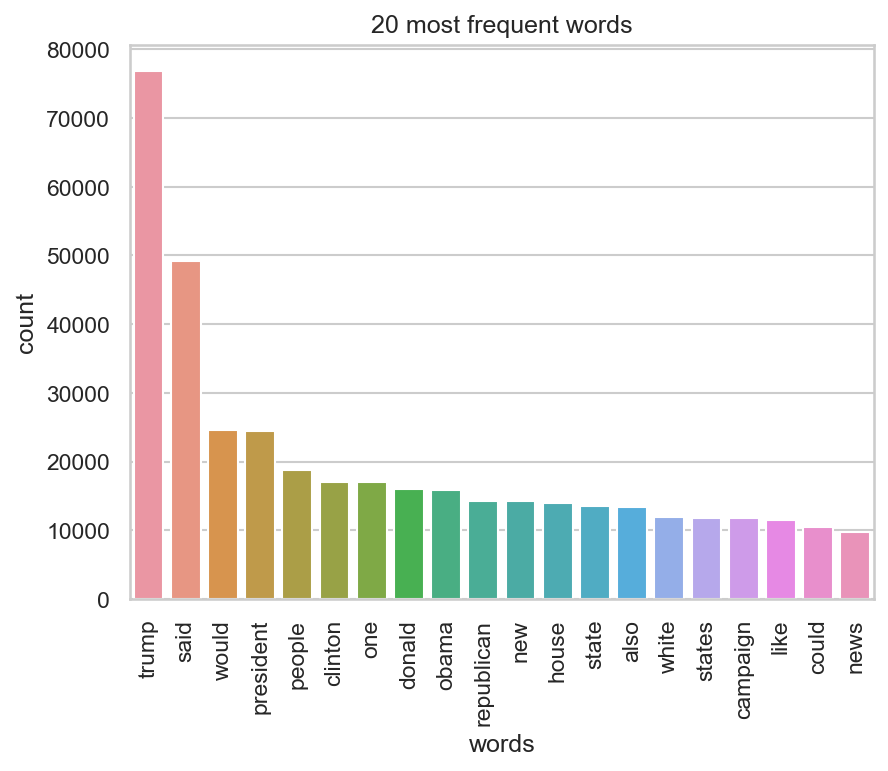

In [ ]:
vect = CountVectorizer(max_features=20)                                                                                                           #define CountVectorizer with max. 20 features

word_counts_vect = vect.fit_transform(X_train_restricted["text"])                                                                                     #fitting the data, i.e. vocabulary, then transform it into a matrix
vocabulary = vect.get_feature_names_out()                                                                                                         #save the features (=words) in a variable
counts = word_counts_vect.sum(axis=0).A1                                                                                                          #calculate the sum of the matrix columnswise, A1 makes it a 1D array

word_counts_dict = dict(zip(vocabulary, counts))                                                                                                  #get tuples of (word, count)
sorted_dict = dict(sorted(word_counts_dict.items(), key=lambda x: x[1], reverse=True))                                                            #sort the dictionary, but reversed, such that the biggest value comes first

print(f"{sorted_dict}\n\n")

plt.figure(dpi=150)
sns.set_theme(style="whitegrid", palette="pastel")
sns.barplot(x=list(sorted_dict.keys()), y=list(sorted_dict.values()))
plt.xticks(rotation=90)
plt.xlabel("words")
plt.ylabel("count")
plt.title("20 most frequent words")
plt.show()

Reuters is not in the list anymore now. This is good. As a test, let´s see what a Decision Tree is doing, just to be sure that the approach is valid.

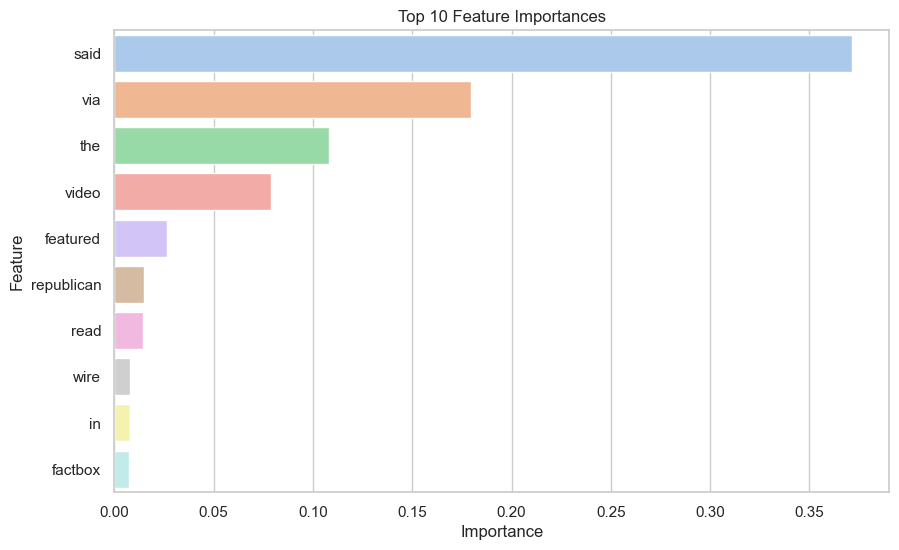

In [ ]:
vectorizer = TfidfVectorizer(max_features=25000)
feature_matrix = vectorizer.fit_transform(X_train_restricted["title_text"])
feature_matrix_test = vectorizer.transform(X_test_restricted["title_text"])
dt = DecisionTreeClassifier()
dt.fit(feature_matrix, y_train_restricted)

class_names = ["True" if label == 1 else "False" for label in np.unique(y_train)]

feature_importances = dt.feature_importances_
indices = np.argsort(feature_importances)[::-1]
top_features = indices[:10]
top_importances = feature_importances[top_features]
feature_names = vectorizer.get_feature_names_out()

plt.figure(figsize=(10, 6))
sns.barplot(x=top_importances, y=[feature_names[i] for i in top_features])
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Top 10 Feature Importances")
plt.show()

Reuters is not in there. This is the result we wanted to see. Let´s now do cross validation and the same procedure as before. A worse score is expected, as the most important word from before is missing now.

In [ ]:
log_reg = LogisticRegression(max_iter=2000)
nb = MultinomialNB()
dt = DecisionTreeClassifier()
rf = RandomForestClassifier()

param_vect = range(5000, 45001, 10000)
models = [log_reg, nb, dt, rf]

best_params_dict = {}

param_grid = {"tfidf__max_df": param_vect,
              "tfidf__ngram_range": [(1, 1), (1, 2)]}

for model in models:
    pipeline = Pipeline([
        ("tfidf", TfidfVectorizer()),
        ("model", model)])

    random_search = RandomizedSearchCV(pipeline, param_grid, cv=3, scoring="accuracy", n_jobs=-1)
    random_search.fit(X_train_restricted["title_text"], y_train_restricted)

    best_params_dict[model.__class__.__name__] = random_search.best_params_

    print(f"{model.__class__.__name__}:")
    print("Best parameters for vectorizer:", random_search.best_params_)
    print("Best mean accuracy:", random_search.best_score_)
    print("Variance of CV scores:", random_search.cv_results_["std_test_score"][random_search.best_index_] ** 2)
    print("\n")

LogisticRegression:
Best parameters for vectorizer: {'tfidf__ngram_range': (1, 1), 'tfidf__max_df': 15000}
Best mean accuracy: 0.9768827381657043
Variance of CV scores: 1.7747612858517647e-06


MultinomialNB:
Best parameters for vectorizer: {'tfidf__ngram_range': (1, 1), 'tfidf__max_df': 5000}
Best mean accuracy: 0.8775301837115731
Variance of CV scores: 3.2827315991515383e-06


DecisionTreeClassifier:
Best parameters for vectorizer: {'tfidf__ngram_range': (1, 1), 'tfidf__max_df': 45000}
Best mean accuracy: 0.9614196844677613
Variance of CV scores: 1.3340050599337441e-05


RandomForestClassifier:
Best parameters for vectorizer: {'tfidf__ngram_range': (1, 1), 'tfidf__max_df': 35000}
Best mean accuracy: 0.9795027463404034
Variance of CV scores: 1.534815973334624e-06




In [ ]:
best_params_modified = {}
for model, params in best_params_dict.items():
    modified_params = {}
    for key, value in params.items():
        new_key = key.replace("tfidf__", "")
        modified_params[new_key] = value
    best_params_modified[model] = modified_params
best_params_modified

{'LogisticRegression': {'ngram_range': (1, 1), 'max_df': 15000},
 'MultinomialNB': {'ngram_range': (1, 1), 'max_df': 5000},
 'DecisionTreeClassifier': {'ngram_range': (1, 1), 'max_df': 45000},
 'RandomForestClassifier': {'ngram_range': (1, 1), 'max_df': 35000}}

Here we can see, that Naive Bayes performs even worse than before. Hence we will drop it again. Decision Tree and RandomForest are also performing worse now. Logistic Regression performs second best.
Let´s fine-tune Logistic Regression first and see what´s going on.

In [ ]:
vectorizer = TfidfVectorizer(**best_params_modified["LogisticRegression"])
feature_matrix = vectorizer.fit_transform(X_train_restricted["title_text"])
feature_matrix_test = vectorizer.transform(X_test_restricted["title_text"])

log_reg = LogisticRegression()
param_grid = {"C": np.logspace(-4, 4, 50),
             "penalty": ["l1", "l2"],
              "solver": ["liblinear", "saga"],
              "max_iter": [1000, 2000, 3000]}

random_search = RandomizedSearchCV(log_reg, param_grid, cv=5, scoring="accuracy", n_jobs=-1)

random_search.fit(feature_matrix, y_train_restricted)

best_params_log_reg = random_search.best_params_
best_score_log_reg = random_search.best_score_

print("Best Parameters:", best_params_log_reg)
print("Best Score:", best_score_log_reg)

Best Parameters: {'solver': 'saga', 'penalty': 'l1', 'max_iter': 1000, 'C': 75.43120063354607}
Best Score: 0.991523669035239


C:\Users\Jan\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Now we see, that the model performs really good. 99,15% is almost the same as before. Please note, that the warning appears because of RandomizedSearch. If run again, it might disappear again.

Let´s now see, how it performs on the test data with these fine-tuned hyperparameters.

Accuracy: 0.9910979228486647 

Classification Report: 
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      5578
           1       0.99      0.99      0.99      2847

    accuracy                           0.99      8425
   macro avg       0.99      0.99      0.99      8425
weighted avg       0.99      0.99      0.99      8425




C:\Users\Jan\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


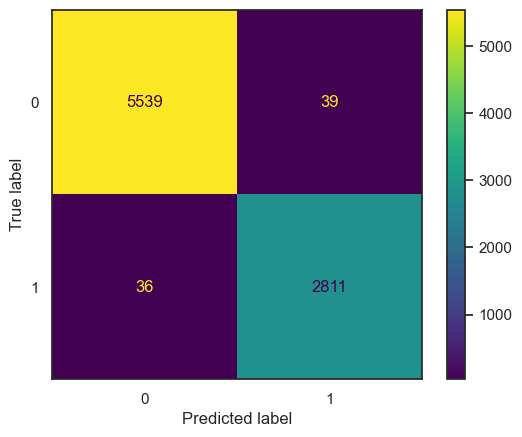

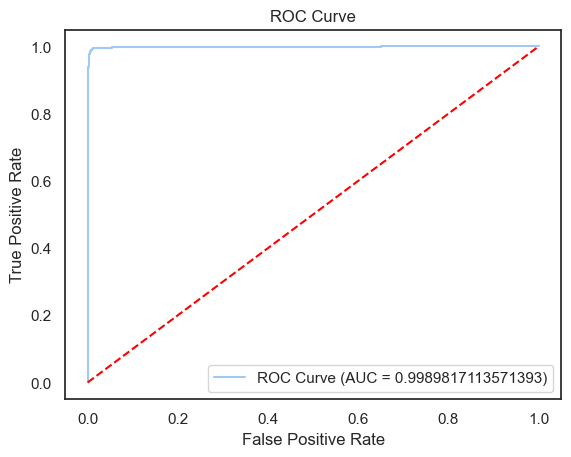

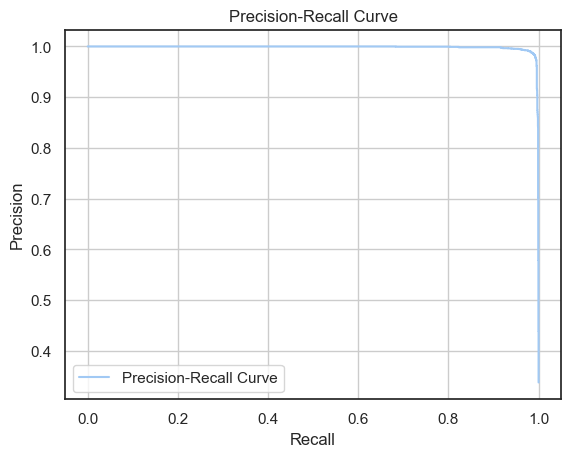

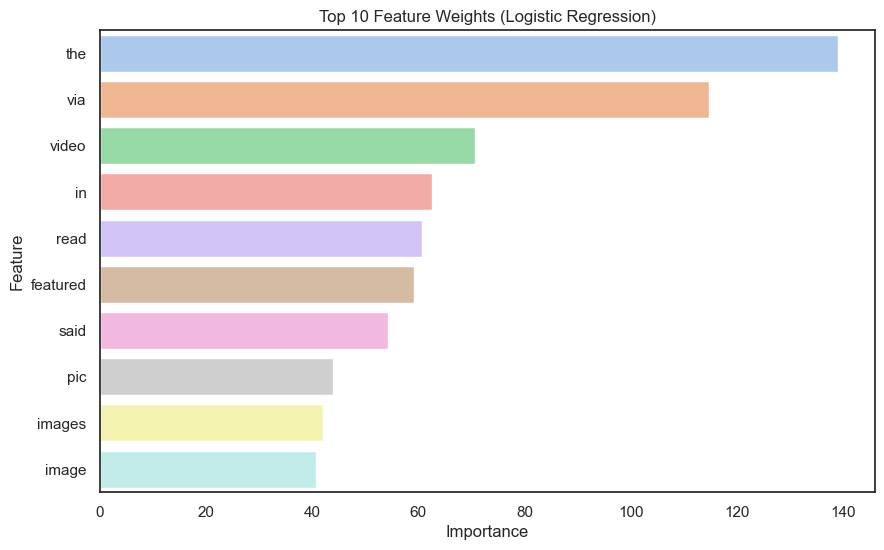

In [ ]:
log_reg = LogisticRegression(**best_params_log_reg)
log_reg.fit(feature_matrix, y_train_restricted)

y_pred = log_reg.predict(feature_matrix_test)
y_proba = log_reg.predict_proba(feature_matrix_test)[:, 1]

accuracy_log_reg = accuracy_score(y_test_restricted, y_pred)
print(f"Accuracy: {accuracy_log_reg} \n")

report_log_reg = classification_report(y_test_restricted, y_pred)
print(f"Classification Report: \n{report_log_reg}\n")

sns.set_style("white")
cm_log_reg = confusion_matrix(y_test_restricted, y_pred, labels=log_reg.classes_)
disp_log_reg = ConfusionMatrixDisplay(confusion_matrix=cm_log_reg, display_labels=log_reg.classes_)
disp_log_reg.plot()
plt.show()

print("\n")

fpr_log_reg, tpr_log_reg, thresholds_log_reg = roc_curve(y_test_restricted, y_proba)
auc_log_reg = roc_auc_score(y_test_restricted, y_proba)

plt.plot(fpr_log_reg, tpr_log_reg, label=f"ROC Curve (AUC = {auc_log_reg})")
plt.plot([0, 1], [0, 1], color="red", linestyle="--")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")

plt.show()

print("\n")

precision, recall, thresholds = precision_recall_curve(y_test_restricted, y_proba)
plt.plot(recall, precision, color="b", label="Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.grid(True)
plt.show()

feature_importances = abs(log_reg.coef_[0])
indices = np.argsort(feature_importances)[::-1]
top_features = indices[:10]
top_importances = feature_importances[top_features]
feature_names = vectorizer.get_feature_names_out()

plt.figure(figsize=(10, 6))
sns.barplot(x=top_importances, y=[feature_names[i] for i in top_features])
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Top 10 Feature Weights (Logistic Regression)")
plt.show()

As expected, Logistic Regression performs really well. In the confusion matrix we can see, that there are twice as much Fake News, as Real News. This was expected, because we know from EDA, that in this time span are more fake news than real news. The importance graph reveals, that the weights of the features are now not focused only on "Reuters". False-negative and False-positive classifications are evenly distributed. There are 75 errors. The rest of the metrics is again really good.

Now let´s look at the Decision Tree. As before, we will fine-tune first.

In [ ]:
vectorizer = TfidfVectorizer(**best_params_modified["DecisionTreeClassifier"])
feature_matrix = vectorizer.fit_transform(X_train_restricted["title_text"])
feature_matrix_test = vectorizer.transform(X_test_restricted["title_text"])

param_grid = {
    "max_depth": [None, 5, 15, 25, 35, 45],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 3, 4],
}


grid_search = RandomizedSearchCV(dt, param_grid, cv=5, scoring="accuracy", n_jobs=-1)

grid_search.fit(feature_matrix, y_train_restricted)

best_params_dt = grid_search.best_params_
best_score_dt = grid_search.best_score_

print("Best Parameters:", best_params_dt)
print("Best Score:", best_score_dt)

Best Parameters: {'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': None}
Best Score: 0.9636290546120009


Now we got the results, which are slightly better than before. Let´s look at how it performs.

Accuracy: 0.9706476530005942 

Classification Report: 
              precision    recall  f1-score   support

           0       0.97      0.98      0.98      5575
           1       0.97      0.95      0.96      2840

    accuracy                           0.97      8415
   macro avg       0.97      0.96      0.97      8415
weighted avg       0.97      0.97      0.97      8415




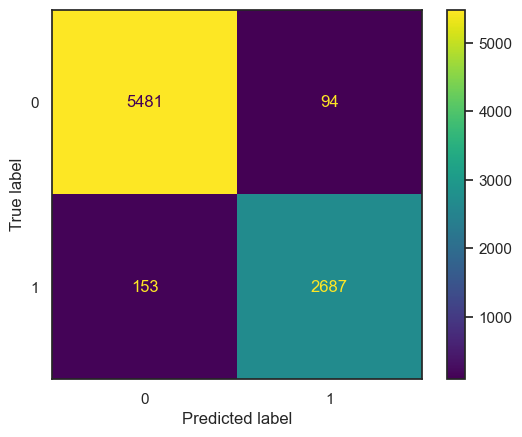

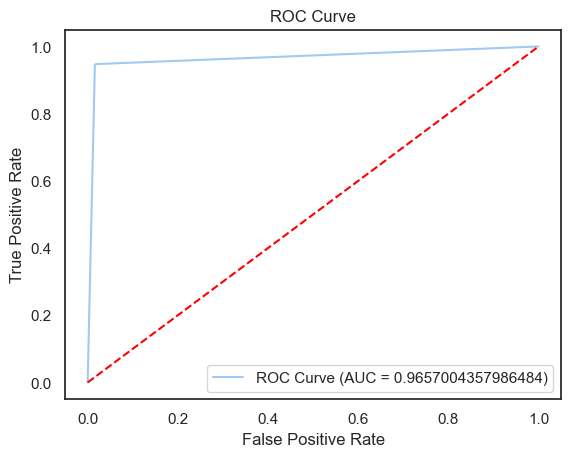

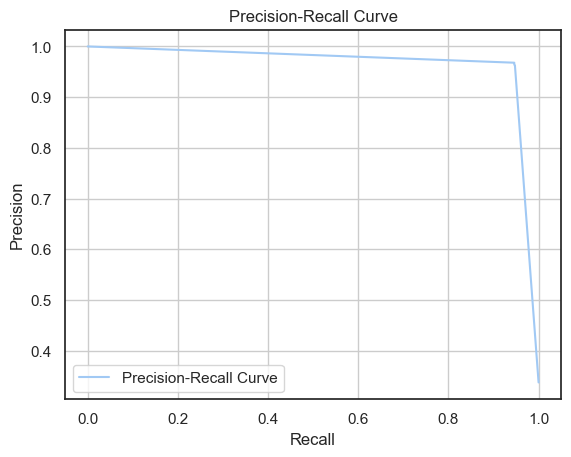

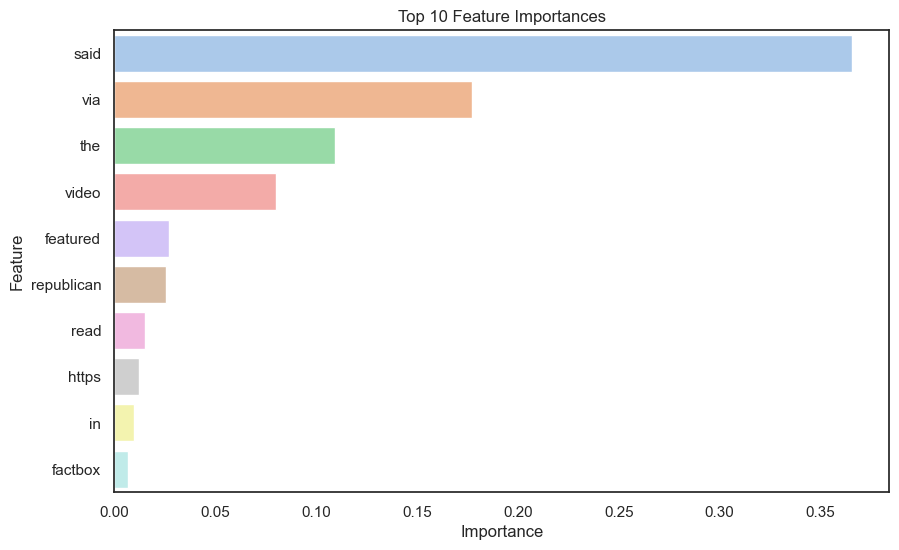

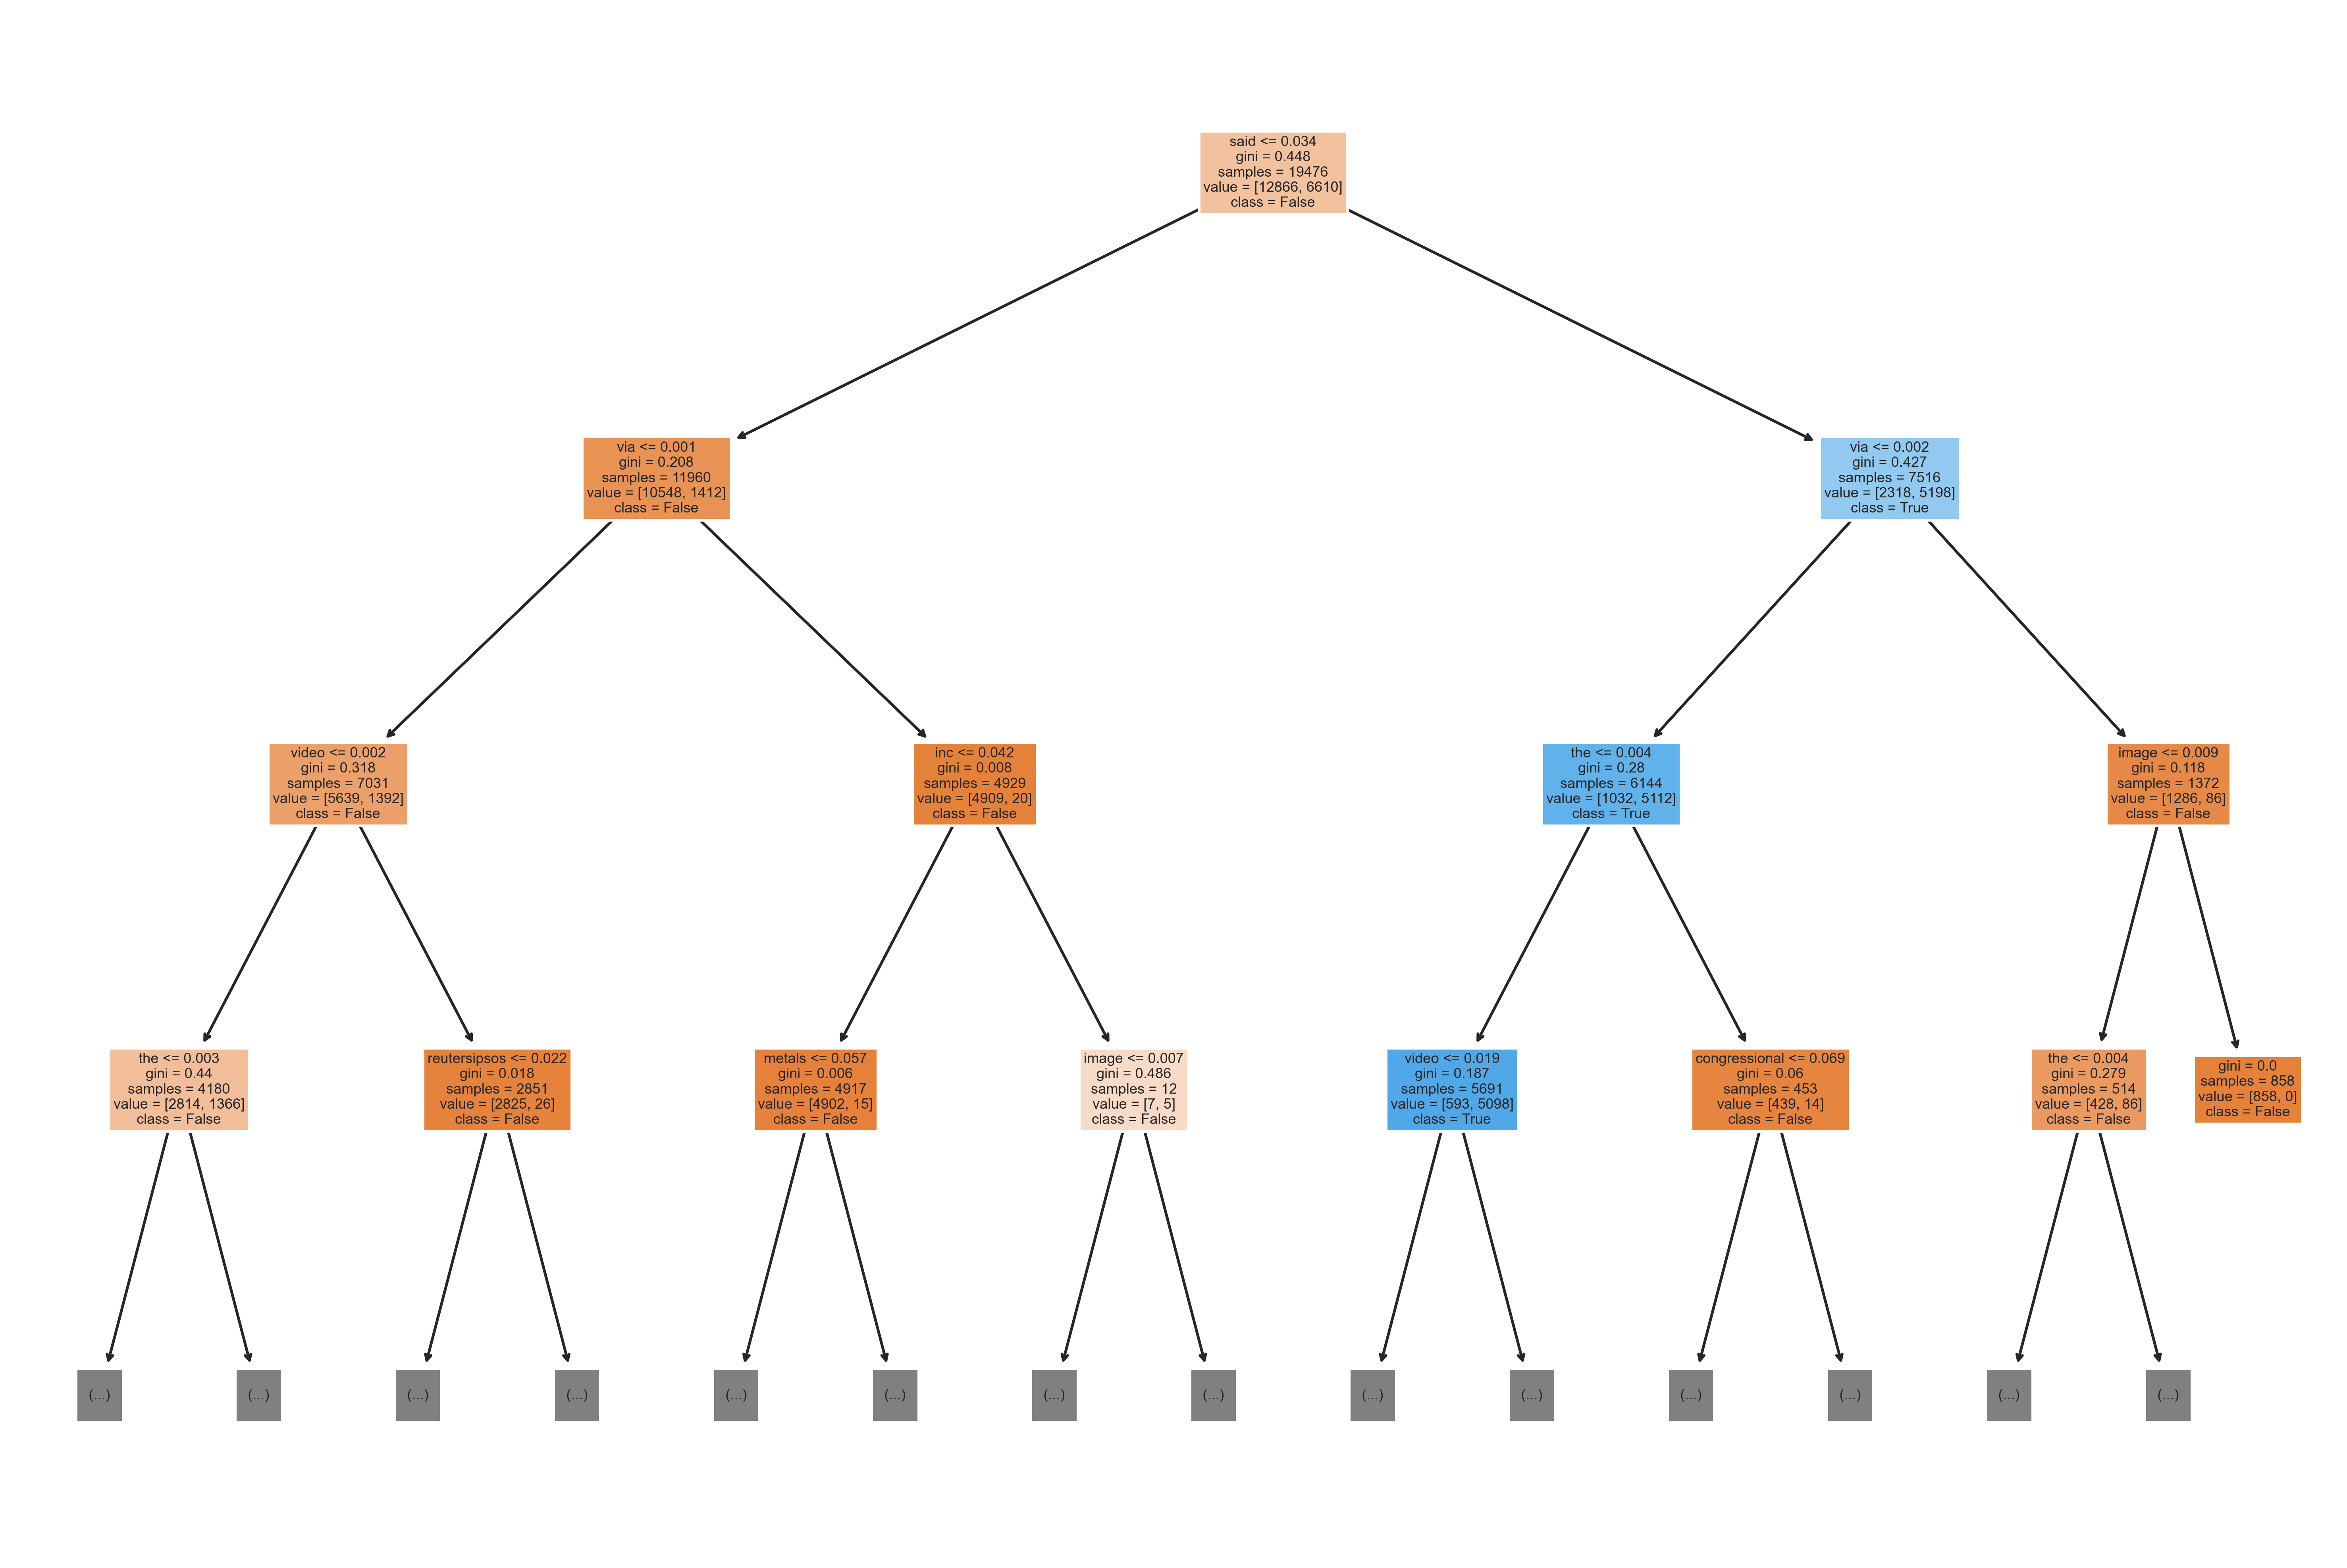

In [ ]:
dt = DecisionTreeClassifier(**best_params_dt)
dt.fit(feature_matrix, y_train_restricted)

y_pred = dt.predict(feature_matrix_test)
y_proba = dt.predict_proba(feature_matrix_test)[:, 1]

accuracy = accuracy_score(y_test_restricted, y_pred)
print(f"Accuracy: {accuracy} \n")

report = classification_report(y_test_restricted, y_pred)
print(f"Classification Report: \n{report}\n")

sns.set_style("white")
cm_dt = confusion_matrix(y_test_restricted, y_pred, labels=dt.classes_)
disp_dt = ConfusionMatrixDisplay(confusion_matrix=cm_dt, display_labels=dt.classes_)
disp_dt.plot()
plt.show()

print("\n")

fpr_dt, tpr_dt, thresholds_dt = roc_curve(y_test_restricted, y_proba)
auc_dt = roc_auc_score(y_test_restricted, y_proba)

plt.plot(fpr_dt, tpr_dt, label=f"ROC Curve (AUC = {auc_dt})")
plt.plot([0, 1], [0, 1], color="red", linestyle="--")

print("\n")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")

plt.show()

print("\n")

precision, recall, thresholds = precision_recall_curve(y_test_restricted, y_proba)
plt.plot(recall, precision, color="b", label="Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.grid(True)
plt.show()

print("\n")

feature_importances = dt.feature_importances_
indices = np.argsort(feature_importances)[::-1]
top_features = indices[:10]
top_importances = feature_importances[top_features]
feature_names = vectorizer.get_feature_names_out()

plt.figure(figsize=(10, 6))
sns.barplot(x=top_importances, y=[feature_names[i] for i in top_features])
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Top 10 Feature Importances")
plt.show()

print("\n")

class_names = ["True" if label == 1 else "False" for label in np.unique(y_train)]

plt.figure(figsize=(15, 10), dpi=500)
tree.plot_tree(dt, feature_names=list(vectorizer.get_feature_names_out()), class_names=class_names, filled=True, max_depth=3)
plt.show()

Here we can see, that the model performs worse now compared to other models. Almost 250 errors are not good. 2/3 of them are labeled fake, despite being true, which makes it even worse - true news being classified as fake are a big problem. Also we can see "https". We did not remove links, because in our opinion they play a role. Fake news may use more links compared to real news. This can be useful information.
Let´s have a look at RandomForest, since a combination of many trees might perform better. Let´s fine-tune first:

In [ ]:
vectorizer = TfidfVectorizer(**best_params_modified["RandomForestClassifier"])
feature_matrix = vectorizer.fit_transform(X_train_restricted["title_text"])
feature_matrix_test = vectorizer.transform(X_test_restricted["title_text"])

rf = RandomForestClassifier()

param_grid = {"n_estimators": [100, 250, 500, 1000],
              "max_depth": [None, 15, 30, 50],
              "max_features": [100, 2000, 5000, None],
              "criterion": ["gini", "entropy"]}

random_search = RandomizedSearchCV(rf, param_grid, cv=3, scoring="accuracy", n_jobs=-1)

random_search.fit(feature_matrix, y_train_restricted)

best_params_rf = random_search.best_params_
best_score_rf = random_search.best_score_

print("Best Parameters:", best_params_rf)
print("Best Score:", best_score_rf)

Best Parameters: {'n_estimators': 1000, 'max_features': 2000, 'max_depth': 50, 'criterion': 'entropy'}
Best Score: 0.9914722578669761


Accuracy: 0.9921568627450981 

Classification Report: 
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      5575
           1       0.99      0.99      0.99      2840

    accuracy                           0.99      8415
   macro avg       0.99      0.99      0.99      8415
weighted avg       0.99      0.99      0.99      8415




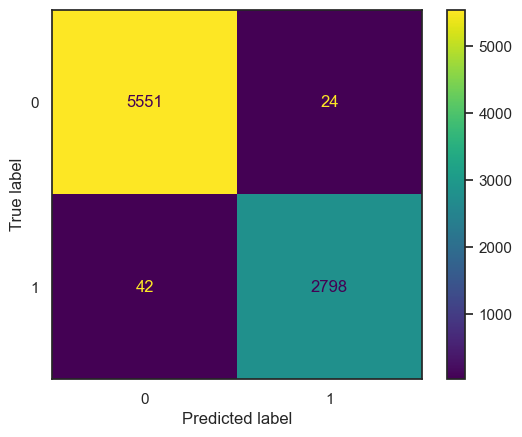

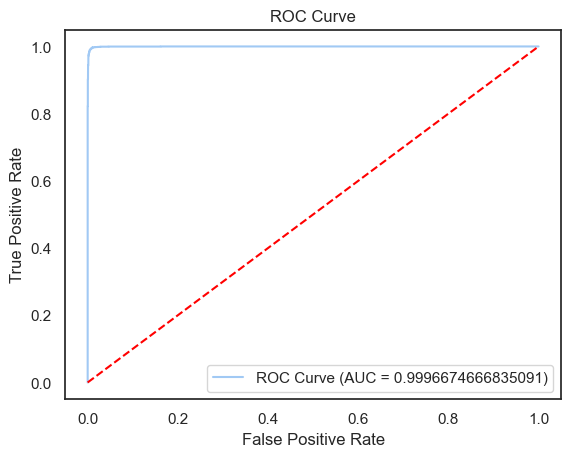

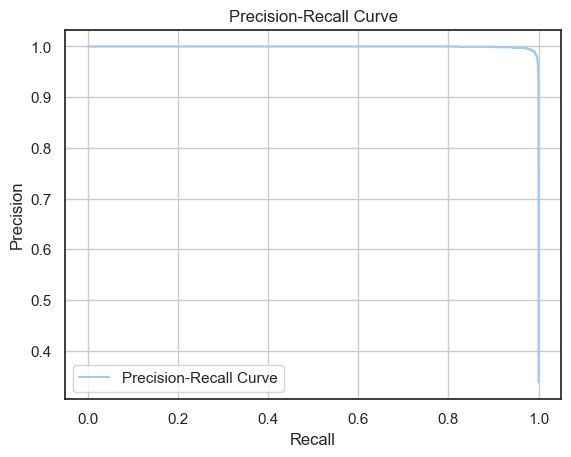

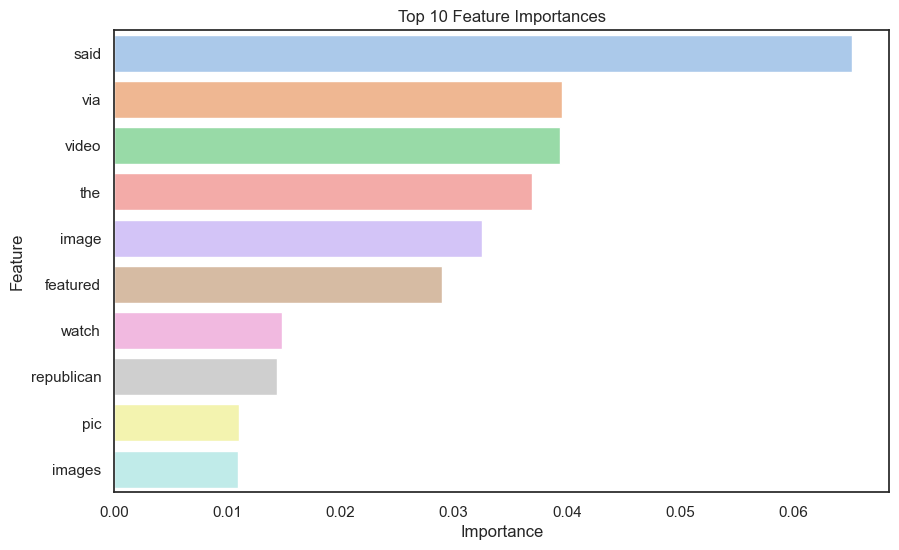

In [ ]:
rf = RandomForestClassifier(**best_params_rf)

rf.fit(feature_matrix, y_train_restricted)

y_pred = rf.predict(feature_matrix_test)
y_proba = rf.predict_proba(feature_matrix_test)[:, 1]

accuracy_rf = accuracy_score(y_test_restricted, y_pred)
print(f"Accuracy: {accuracy_rf} \n")

report_rf = classification_report(y_test_restricted, y_pred)
print(f"Classification Report: \n{report_rf}\n")

sns.set_style("white")
cm_rf = confusion_matrix(y_test_restricted, y_pred, labels=rf.classes_)
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=rf.classes_)
disp_rf.plot()
plt.show()

print("\n")

fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test_restricted, y_proba)
auc_rf = roc_auc_score(y_test_restricted, y_proba)

plt.plot(fpr_rf, tpr_rf, label=f"ROC Curve (AUC = {auc_rf})")
plt.plot([0, 1], [0, 1], color="red", linestyle="--")

print("\n")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")

plt.show()

print("\n")

precision, recall, thresholds = precision_recall_curve(y_test_restricted, y_proba)
plt.plot(recall, precision, color="b", label="Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.grid(True)
plt.show()

print("\n")

feature_importances = rf.feature_importances_
indices = np.argsort(feature_importances)[::-1]
top_features = indices[:10]
top_importances = feature_importances[top_features]
feature_names = vectorizer.get_feature_names_out()

plt.figure(figsize=(10, 6))
sns.barplot(x=top_importances, y=[feature_names[i] for i in top_features])
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Top 10 Feature Importances")
plt.show()

At this point we can conclude, that Random Forest still performs best with 66 errors. An interesting oberservation here is, that Decision Tree has around 30% importance on "said", Random Forest has more evenly distributed Feature Importances.
We now know, that Random Forest performs best as well for the biased data set with very strong indicators like "Reuters" as for the same text data without these words. It is silghtly worse with restricted data, which is very obvious, but is still very reliable.
Now we will go on with a little experiment. We always combined text and title, since our thought process was that it is in some way redundant. The title is just a very short summary of the text. However, as an experiment to gain insight for these algorithms, we will now use the models from this task and apply them to the text and title data seperately. We will see what that does. Our guess is, that it performs the exact same, in case this is not true, we will see why.
To achieve this, we will use the Vectorizer on both columns and then concatenate the matrices. After that we can use one matrix as usual. Let´s define this matrix first.
We will start with Logistic Regression.

In [ ]:
vectorizer = TfidfVectorizer(**best_params_modified["LogisticRegression"])

vectorizer_title = TfidfVectorizer(**best_params_modified["LogisticRegression"])
feature_matrix_title = vectorizer_title.fit_transform(X_train_restricted["title"])

vectorizer_text = TfidfVectorizer(**best_params_modified["LogisticRegression"])
feature_matrix_text = vectorizer_text.fit_transform(X_train_restricted["text"])

feature_matrix_title_test = vectorizer_title.transform(X_test_restricted["title"])
feature_matrix_text_test = vectorizer_text.transform(X_test_restricted["text"])

combined_feature_matrix = sp.hstack((feature_matrix_title, feature_matrix_text))
combined_feature_matrix_test = sp.hstack((feature_matrix_title_test, feature_matrix_text_test))

log_reg = LogisticRegression()

param_grid = {"C": np.logspace(-4, 4, 50),
             "penalty": ["l1", "l2"],
              "solver": ["liblinear", "saga"],
              "max_iter": [1000, 2000, 3000]}

random_search = RandomizedSearchCV(log_reg, param_grid, cv=5, scoring="accuracy", n_jobs=-1)

random_search.fit(combined_feature_matrix, y_train_restricted)

best_params_log_reg = random_search.best_params_
best_score_log_reg = random_search.best_score_

print("Best Parameters:", best_params_log_reg)
print("Best Score:", best_score_log_reg)

Best Parameters: {'solver': 'liblinear', 'penalty': 'l1', 'max_iter': 2000, 'C': 232.99518105153672}
Best Score: 0.994143624439636


Accuracy: 0.9935905044510386 

Classification Report: 
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      5578
           1       0.99      0.99      0.99      2847

    accuracy                           0.99      8425
   macro avg       0.99      0.99      0.99      8425
weighted avg       0.99      0.99      0.99      8425




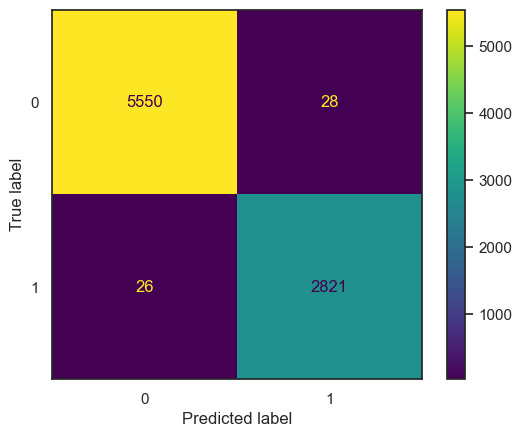

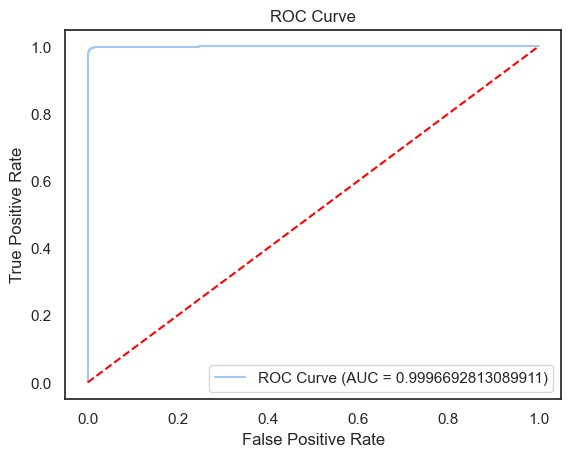

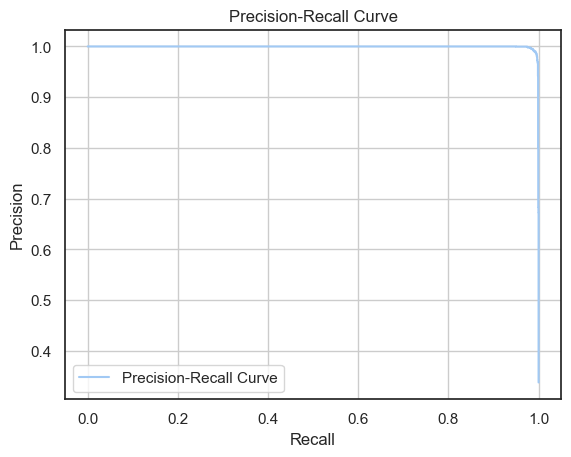

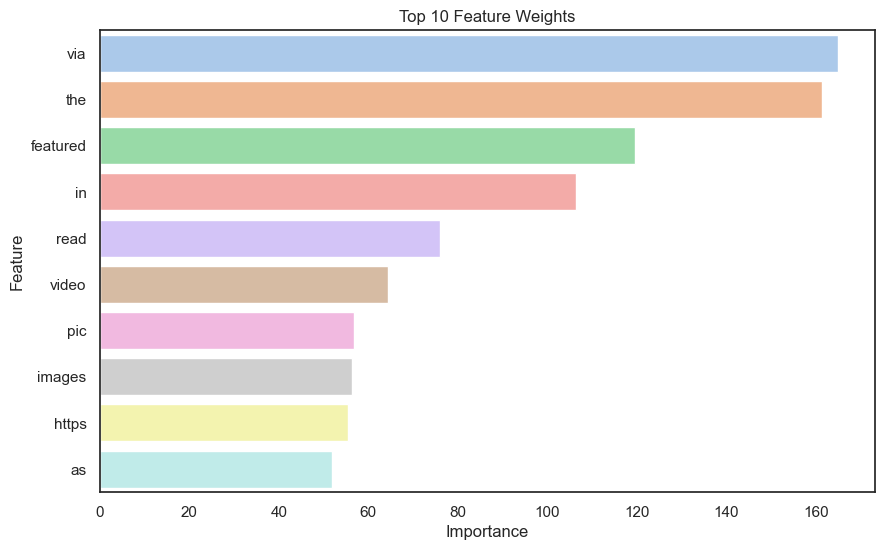

In [ ]:
log_reg = LogisticRegression(**best_params_log_reg)
log_reg.fit(combined_feature_matrix, y_train_restricted)

y_pred = log_reg.predict(combined_feature_matrix_test)
y_proba = log_reg.predict_proba(combined_feature_matrix_test)[:, 1]

accuracy_log_reg = accuracy_score(y_test_restricted, y_pred)
print(f"Accuracy: {accuracy_log_reg} \n")

report_log_reg = classification_report(y_test_restricted, y_pred)
print(f"Classification Report: \n{report_log_reg}\n")

sns.set_style("white")
cm_log_reg = confusion_matrix(y_test_restricted, y_pred, labels=log_reg.classes_)
disp_log_reg = ConfusionMatrixDisplay(confusion_matrix=cm_log_reg, display_labels=log_reg.classes_)
disp_log_reg.plot()
plt.show()

print("\n")

fpr_log_reg, tpr_log_reg, thresholds_log_reg = roc_curve(y_test_restricted, y_proba)
auc_log_reg = roc_auc_score(y_test_restricted, y_proba)

plt.plot(fpr_log_reg, tpr_log_reg, label=f"ROC Curve (AUC = {auc_log_reg})")
plt.plot([0, 1], [0, 1], color="red", linestyle="--")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")

plt.show()

print("\n")

precision, recall, thresholds = precision_recall_curve(y_test_restricted, y_proba)
plt.plot(recall, precision, color="b", label="Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.grid(True)
plt.show()


feature_importances = abs(log_reg.coef_[0])
indices = np.argsort(feature_importances)[::-1]
top_features = indices[:10]
top_importances = feature_importances[top_features]
feature_names = np.concatenate([vectorizer_title.get_feature_names_out(), vectorizer_text.get_feature_names_out()])

plt.figure(figsize=(10, 6))
sns.barplot(x=top_importances, y=[feature_names[i] for i in top_features])
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Top 10 Feature Weights")
plt.show()

It turns out, that this shows almost the exact same results with a tendency to be slightly better. This is against our prior assumption, that combining **title** and **text** does not change accuracy. As this revealed something we were not aware of, we will also cover the other 2 algorithms and see, whether the same things happens there.  Logistic Regression now has 99.35% accuracy with 54 errors, which are 50/50 split. The data set is biased, but the F1-score is still 0.99, which is very good. The distribution of importances is also relatively evenly distributed.
Let´s go on with Decision Tree.

In [ ]:
dt = DecisionTreeClassifier()

vectorizer = TfidfVectorizer(**best_params_modified["DecisionTreeClassifier"])

vectorizer_title = TfidfVectorizer(**best_params_modified["DecisionTreeClassifier"])
feature_matrix_title = vectorizer_title.fit_transform(X_train_restricted["title"])

vectorizer_text = TfidfVectorizer(**best_params_modified["DecisionTreeClassifier"])
feature_matrix_text = vectorizer_text.fit_transform(X_train_restricted["text"])

feature_matrix_title_test = vectorizer_title.transform(X_test_restricted["title"])
feature_matrix_text_test = vectorizer_text.transform(X_test_restricted["text"])

combined_feature_matrix = sp.hstack((feature_matrix_title, feature_matrix_text))
combined_feature_matrix_test = sp.hstack((feature_matrix_title_test, feature_matrix_text_test))

param_grid = {
    "max_depth": [None, 5, 15, 25, 35, 45],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 3, 4],
}


grid_search = RandomizedSearchCV(dt, param_grid, cv=5, scoring="accuracy", n_jobs=-1)

grid_search.fit(combined_feature_matrix, y_train_restricted)

best_params_dt = grid_search.best_params_
best_score_dt = grid_search.best_score_

print("Best Parameters:", best_params_dt)
print("Best Score:", best_score_dt)

Best Parameters: {'min_samples_split': 10, 'min_samples_leaf': 2, 'max_depth': 25}
Best Score: 0.964861852183294


Accuracy: 0.9670825906120024 

Classification Report: 
              precision    recall  f1-score   support

           0       0.97      0.98      0.98      5575
           1       0.96      0.94      0.95      2840

    accuracy                           0.97      8415
   macro avg       0.97      0.96      0.96      8415
weighted avg       0.97      0.97      0.97      8415




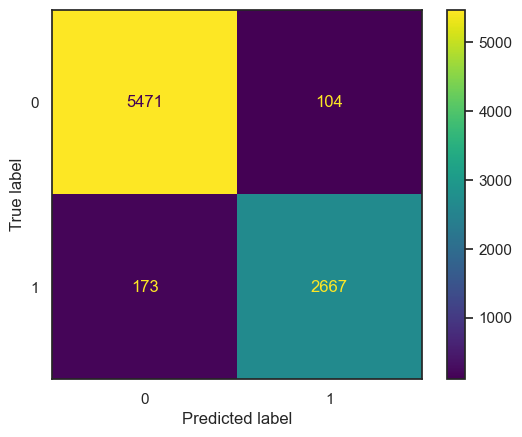

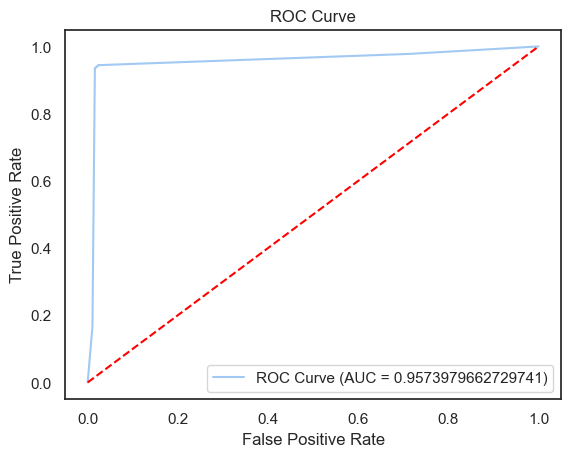

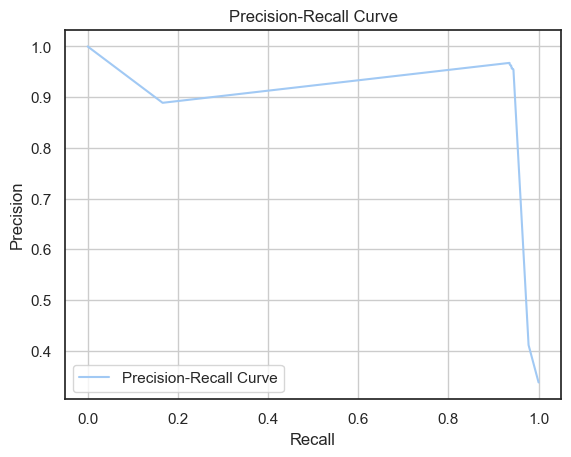

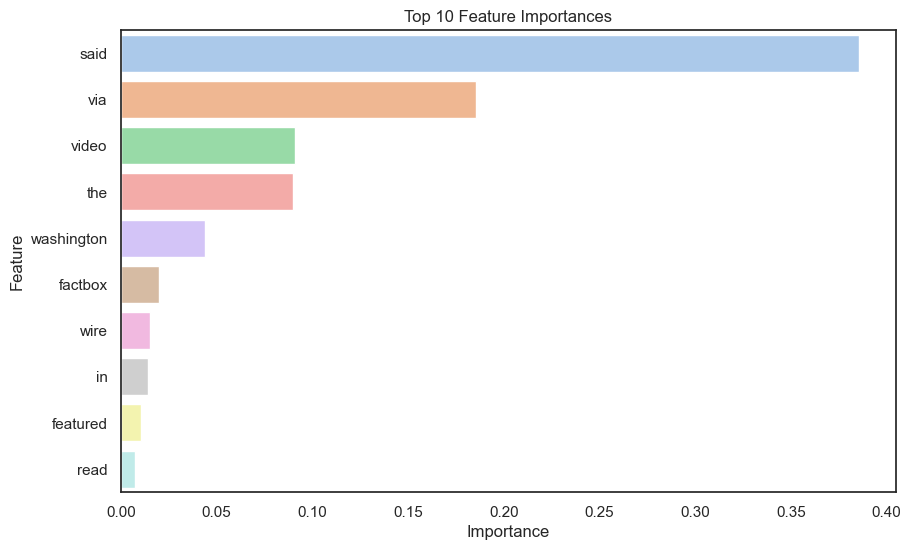

In [ ]:
dt = DecisionTreeClassifier(**best_params_dt)
dt.fit(combined_feature_matrix, y_train_restricted)

y_pred = dt.predict(combined_feature_matrix_test)
y_proba = dt.predict_proba(combined_feature_matrix_test)[:, 1]

accuracy = accuracy_score(y_test_restricted, y_pred)
print(f"Accuracy: {accuracy} \n")

report = classification_report(y_test_restricted, y_pred)
print(f"Classification Report: \n{report}\n")

sns.set_style("white")
cm_dt = confusion_matrix(y_test_restricted, y_pred, labels=dt.classes_)
disp_dt = ConfusionMatrixDisplay(confusion_matrix=cm_dt, display_labels=dt.classes_)
disp_dt.plot()
plt.show()

print("\n")

fpr_dt, tpr_dt, thresholds_dt = roc_curve(y_test_restricted, y_proba)
auc_dt = roc_auc_score(y_test_restricted, y_proba)

plt.plot(fpr_dt, tpr_dt, label=f"ROC Curve (AUC = {auc_dt})")
plt.plot([0, 1], [0, 1], color="red", linestyle="--")

print("\n")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")

plt.show()

print("\n")

precision, recall, thresholds = precision_recall_curve(y_test_restricted, y_proba)
plt.plot(recall, precision, color="b", label="Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.grid(True)
plt.show()

print("\n")

feature_importances = dt.feature_importances_
indices = np.argsort(feature_importances)[::-1]
top_features = indices[:10]
top_importances = feature_importances[top_features]
feature_names = np.concatenate([vectorizer_title.get_feature_names_out(), vectorizer_text.get_feature_names_out()])

plt.figure(figsize=(10, 6))
sns.barplot(x=top_importances, y=[feature_names[i] for i in top_features])
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Top 10 Feature Importances")
plt.show()

Here we can see the results for the Decision Tree. 96% is worse than before. This is a bit surprising. Also the AUC is worse and the graph is not as close to the left upper corner as before. It still makes way more errors, namely again true news as fake, which is really bad. Decision tree is not really good for this task. It is doing the opposite to Logistic Regression here.
Now we finalize it with Random Forest.

In [ ]:
rf = RandomForestClassifier()

vectorizer = TfidfVectorizer(**best_params_modified["RandomForestClassifier"])

vectorizer_title = TfidfVectorizer(**best_params_modified["RandomForestClassifier"])
feature_matrix_title = vectorizer_title.fit_transform(X_train_restricted["title"])

vectorizer_text = TfidfVectorizer(**best_params_modified["RandomForestClassifier"])
feature_matrix_text = vectorizer_text.fit_transform(X_train_restricted["text"])

feature_matrix_title_test = vectorizer_title.transform(X_test_restricted["title"])
feature_matrix_text_test = vectorizer_text.transform(X_test_restricted["text"])

combined_feature_matrix = sp.hstack((feature_matrix_title, feature_matrix_text))
combined_feature_matrix_test = sp.hstack((feature_matrix_title_test, feature_matrix_text_test))

param_grid = {"n_estimators": [100, 250, 500, 1000],
              "max_depth": [None, 15, 30, 50],
              "max_features": [100, 2000, 5000, None],
              "criterion": ["gini", "entropy"]}

random_search = RandomizedSearchCV(rf, param_grid, cv=3, scoring="accuracy", n_jobs=-1)

random_search.fit(combined_feature_matrix, y_train_restricted)

best_params_rf = random_search.best_params_
best_score_rf = random_search.best_score_

print("Best Parameters:", best_params_rf)
print("Best Score:", best_score_rf)

Best Parameters: {'n_estimators': 500, 'max_features': 2000, 'max_depth': 30, 'criterion': 'entropy'}
Best Score: 0.9902957486136783


Accuracy: 0.9921837991473236 

Classification Report: 
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      5644
           1       0.99      0.98      0.99      2800

    accuracy                           0.99      8444
   macro avg       0.99      0.99      0.99      8444
weighted avg       0.99      0.99      0.99      8444




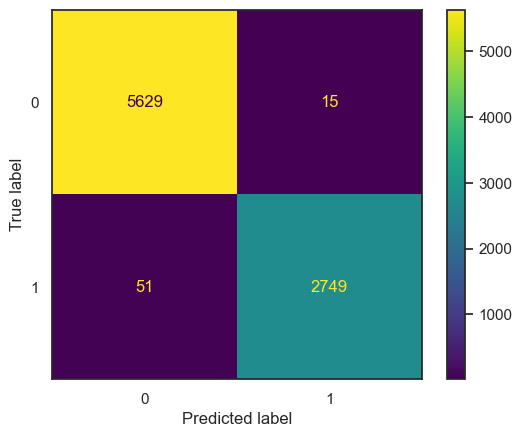

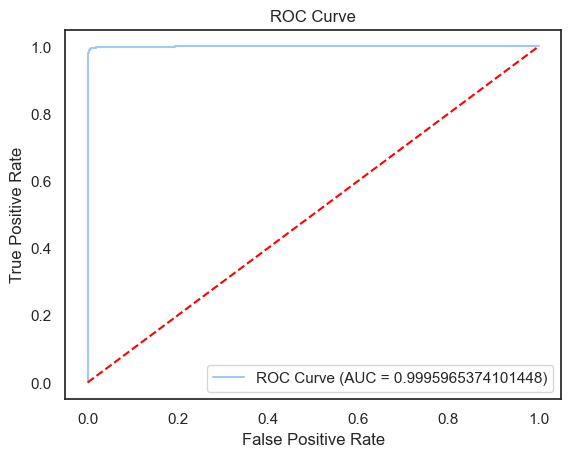

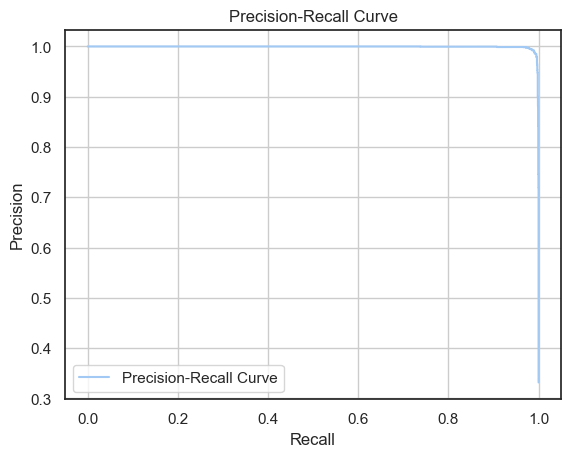

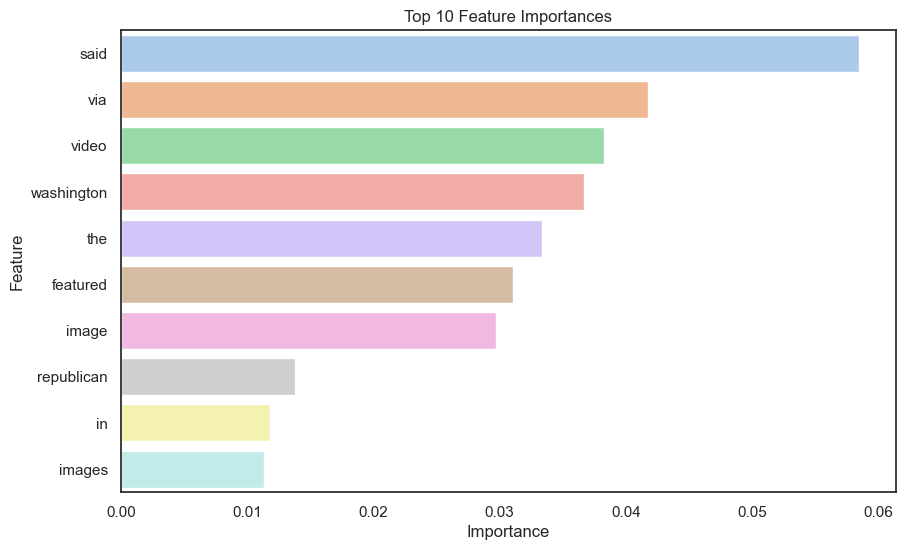

In [ ]:
rf = RandomForestClassifier()

vectorizer = TfidfVectorizer(**{'ngram_range': (1, 1), 'max_df': 35000})

vectorizer_title = TfidfVectorizer(**{'ngram_range': (1, 1), 'max_df': 35000})
feature_matrix_title = vectorizer_title.fit_transform(X_train_restricted["title"])

vectorizer_text = TfidfVectorizer(**{'ngram_range': (1, 1), 'max_df': 35000})
feature_matrix_text = vectorizer_text.fit_transform(X_train_restricted["text"])

feature_matrix_title_test = vectorizer_title.transform(X_test_restricted["title"])
feature_matrix_text_test = vectorizer_text.transform(X_test_restricted["text"])

combined_feature_matrix = sp.hstack((feature_matrix_title, feature_matrix_text))
combined_feature_matrix_test = sp.hstack((feature_matrix_title_test, feature_matrix_text_test))


rf = RandomForestClassifier(**{'n_estimators': 500, 'max_features': 2000, 'max_depth': 30, 'criterion': 'entropy'})

rf.fit(combined_feature_matrix, y_train_restricted)

y_pred = rf.predict(combined_feature_matrix_test)
y_proba = rf.predict_proba(combined_feature_matrix_test)[:, 1]

accuracy_rf = accuracy_score(y_test_restricted, y_pred)
print(f"Accuracy: {accuracy_rf} \n")

report_rf = classification_report(y_test_restricted, y_pred)
print(f"Classification Report: \n{report_rf}\n")

sns.set_style("white")
cm_rf = confusion_matrix(y_test_restricted, y_pred, labels=rf.classes_)
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=rf.classes_)
disp_rf.plot()
plt.show()

print("\n")

fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test_restricted, y_proba)
auc_rf = roc_auc_score(y_test_restricted, y_proba)

plt.plot(fpr_rf, tpr_rf, label=f"ROC Curve (AUC = {auc_rf})")
plt.plot([0, 1], [0, 1], color="red", linestyle="--")

print("\n")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")

plt.show()

print("\n")

precision, recall, thresholds = precision_recall_curve(y_test_restricted, y_proba)
plt.plot(recall, precision, color="b", label="Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.grid(True)
plt.show()

print("\n")

feature_importances = rf.feature_importances_
indices = np.argsort(feature_importances)[::-1]
top_features = indices[:10]
top_importances = feature_importances[top_features]
feature_names = np.concatenate([vectorizer_title.get_feature_names_out(), vectorizer_text.get_feature_names_out()])

plt.figure(figsize=(10, 6))
sns.barplot(x=top_importances, y=[feature_names[i] for i in top_features])
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Top 10 Feature Importances")
plt.show()

Here we can discover something very interesting. The accuracy of Random Forest is lower than from Logistic Regression, but Random Forest makes less errors. The only explanation we can think of is that this is caused by the imbalance of the new data set. Despite that, we see that the importances are again evenly split but the errors are again labeled as fake although it is true. Logistic Regression does not do this, which leads us to the conclusion that Logistic Regression works best out of the classification models. It makes more errors, but the errors are not as bad as from Random Forest. We think that the misclassification of true news might spread more insecurity and instability within society than fake news, which are classified as true.

As a summary, let´s have a look at the F1-score of every model:


| Model | All data (31.3.2015 - 19.2.2018): Text, Title combined | Restricted (8.1.2016 - 30.8.2017): Text, Title combined  | Restricted (8.1.2016 - 30.8.2017): Text and Title seperately |
| --- | -------- | -------- | -------- |
| **Logistic Regression**   | 1.00   | 0.99   | 0.99   |
| **Naive Bayes**   | 0.96 (accuracy)   | 0.88 (accuracy)   | *N/A*   |
| **Decision Tree**   | 1.00   | 0.97   | 0.97   |
| **Random Forest**   | 1.00   | 0.99   | 0.99   |
| **Gradient Boosting**   | 0.99 (accuracy)   | *N/A*   | *N/A*   |

Looking at the F1-score table, we can determine that the machine learning classification algorithms perform exceptionally well in discerning if a certain article is regarded as "Fake news" or "True news". Provided with all the biased data and after fine-tuning the hyperparameters, we seem to have created a perfect classification algorithm for Logistic Regression, Decision Tree and Random Forest. As we know that achieving a perfect F1-score of 1.0 is extremely unlikely, we suspect that rounding the number to a 3-significant number caused the perfect F1-score. Even after restrictions, the models perform really well. Due to the biased nature of the text data, we have determined that the news source played a crucial role as Reuters was almost only prevalent in the True news, hence proving that we could technically check for one word. We suggest using RandomForest, as this is the most constant model. If training time is a concern, Logistic Regressin offers a good trade-off between time and accuracy.

## Conclusion
In conclusion, we believe that it is entirely possible to detect fake news with supervised machine learning. Of course, this is associated with enormous effort on the part of the creation of the data set, as well as with a huge computation effort. We have also shown that the machine learning models are extremely susceptible to formatting errors or words that only occur in True or Fake. The quality of the dataset is crucial here. Above all, however, it must be constantly updated. Our model may work for 2015 to 2018, but it does not know Covid, for example, and will reach its limits here. The quality of the data set determines the accuracy of the models. If this is guaranteed, a classification of fake news is very well possible.